<a href="https://colab.research.google.com/github/yakaralar/IE492/blob/master/Decision_Trees_LGB_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import glob
import shutil
os.listdir()

['.config', 'drive', 'sample_data']

In [0]:
os.listdir("drive/My Drive/colab_datas/IE 492")

['Comparison of methods.pdf',
 '1-s2.0-S1364032114000914-main.pdf',
 '1-s2.0-S0360544209002539-main.pdf',
 '1-s2.0-S1876610211043116-main.pdf',
 '1-s2.0-S0305048311001423-main.pdf',
 'weather_turkey_processed.zip',
 'Meta_L_makaleler',
 'all_data.feather',
 'UECM-15012015-20022020.csv',
 'RealTimeConsumption-01122014-09032020.csv',
 'updated_support-date_based_information.r',
 'ozel_gunler',
 'RealTimeConsumption_unholidayized.csv',
 'RealTimeConsumption_unhol_decomposed.csv',
 'RealTimeConsumption_holiday.csv',
 'kubi_preds',
 'arima_preds.csv',
 'arima_preds_datetime.csv',
 'gpw_v4_admin_unit_center_points_population_estimates_rev11_tur.csv',
 'gpw-v4-country-level-summary-rev11.xlsx',
 'gpw-v4-documentation-rev11.pdf',
 'kubi_weather_data_20151231-2020-04-02.csv',
 'kubi_temp_humid_wind_data_20151231-2020-04-02.csv',
 'lasso_coeffs_new.csv',
 'Consumption_special_days_v2.csv']

In [0]:
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption_unholidayized.csv","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/updated_support-date_based_information.r","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption-01122014-09032020.csv","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption_holiday.csv","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/kubi_temp_humid_wind_data_20151231-2020-04-02.csv","./")

'./kubi_temp_humid_wind_data_20151231-2020-04-02.csv'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Evaluation function

In [0]:
!pip install graphviz
!pip install sklearn --upgrade
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,plot_tree

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

eval_df=[]
def eval_function(name_,y_true, y_pred,valid_df):
    """
    docstring denir buraya func paramlarının neler oldugunu yazarsınız
    name_:kullanılan modelin ismi
    y_true:actual values
    y_pred:predicted values
    valid_df:modele verdiginiz sekliyle validation dataframe'i ve yanına datetime'ı
    """
    rmse_=np.sqrt(mean_squared_error(y_true,y_pred))
    rmsle_=np.sqrt(mean_squared_log_error(y_true,y_pred))
    mae_=mean_absolute_error(y_true,y_pred)
    mape_=mean_absolute_percentage_error(y_true, y_pred)

    print("RMSE: ",rmse_)
    print("RMSLE: ",rmsle_)
    print("MAE: ",mae_)
    print("MAPE: ",mape_)
    plt.figure(figsize=(16,10))
    sns.scatterplot(x=y_pred,y=y_true)
    plt.pause(0.01)
    plt.figure(figsize=(16,10))
    sns.residplot(y_true,y_pred)
    plt.pause(0.01)
    nchunks=6 # plot count
    fig,ax=plt.subplots(nrows=nchunks,figsize=(32,25))
    valid_copy=valid_df.reset_index(drop=True).copy()
    for i,datetime_ in enumerate(np.array_split(valid_copy["Datetime"],nchunks)):
        sns.lineplot(y=y_true[datetime_.index.tolist()],x=datetime_,color="green",ax=ax[i])
        sns.lineplot(y=y_pred[datetime_.index.tolist()],x=datetime_,color="red",ax=ax[i])
    plt.pause(0.01)
    res_model=DecisionTreeRegressor(max_depth=4)
    _, ax = plt.subplots(figsize=(60, 60))  # whatever size you want
    fig=res_model.fit(valid_df.drop(columns=["Datetime"]),y_true-y_pred)
    plot_tree(fig,ax=ax,feature_names=valid_df.drop(columns=["Datetime"]).columns,fontsize=16)
    plt.pause(0.01)
    ## saatlik mape tanımla
    return name_, rmse_,rmsle_,mae_,mape_

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


# Consumption df

In [0]:
# bruuuuuuuh
cons_unholidayized=pd.read_csv("RealTimeConsumption_unholidayized.csv",encoding='latin-1')
cons_unholidayized.columns=["Date","Hour","Consumption"]+cons_unholidayized.columns.tolist()[3:]
cons_unholidayized["Datetime"]=cons_unholidayized["Date"]+" "+cons_unholidayized["Hour"]
cons_unholidayized["Datetime"]=pd.to_datetime(cons_unholidayized["Datetime"],format="%d.%m.%Y %H:%M")
cons_unholidayized.head(5)

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0  31.12.2015  00:00  ...         38.254867             0.0
1  31.12.2015  01:00  ...         38.254867             0.0
2  31.12.2015  02:00  ...         38.254867             0.0
3  31.12.2015  03:00  ...         38.254867             0.0
4  31.12.2015  04:00  ...         38.254867             0.0

[5 rows x 43 columns]

In [0]:
# bruuuuuuuh
cons_holiday_binary=pd.read_csv("RealTimeConsumption_holiday.csv",encoding='latin-1')
cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
cons_holiday_binary.head()

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0  31.12.2015  00:00  ...                 1               0
1  31.12.2015  01:00  ...                 1               0
2  31.12.2015  02:00  ...                 1               0
3  31.12.2015  03:00  ...                 1               0
4  31.12.2015  04:00  ...                 1               0

[5 rows x 43 columns]

In [0]:
weather_data=pd.read_csv('kubi_temp_humid_wind_data_20151231-2020-04-02.csv')
weather_data=weather_data.rename(columns={"rounded_date":"Datetime"})
weather_data["Datetime"]=pd.to_datetime(weather_data["Datetime"])
weather_data

Datetime  ...  windspeed_Iskenderun
0     2015-12-31 00:00:00  ...             18.400000
1     2015-12-31 01:00:00  ...             16.600000
2     2015-12-31 02:00:00  ...             14.800000
3     2015-12-31 03:00:00  ...             13.000000
4     2015-12-31 04:00:00  ...              9.266667
...                   ...  ...                   ...
37292 2020-04-01 20:00:00  ...              5.100000
37293 2020-04-01 21:00:00  ...              4.950000
37294 2020-04-01 22:00:00  ...              4.800000
37295 2020-04-01 23:00:00  ...              4.650000
37296 2020-04-02 00:00:00  ...              4.500000

[37297 rows x 153 columns]

In [0]:
cons_unholidayized=pd.merge(cons_unholidayized,weather_data,on="Datetime",how="left")
cons_holiday_binary=pd.merge(cons_holiday_binary,weather_data,on="Datetime",how="left")

In [0]:
cons_holiday_binary.isna().sum().sum(),cons_unholidayized.isna().sum().sum()

# weather comparison

In [0]:
#shutil.copy("drive/My Drive/colab_datas/IE 492/weather_turkey_processed.zip","./")
#!unzip weather_turkey_processed.zip
weathers=[]
for path in tqdm(glob.glob("weather_turkey_processed/*.csv")):
    weathers.append(pd.read_csv(path)[['forecast_epoch','lon','lat','TMP_2.m.above.ground']])
weathers=pd.concat(weathers)
weathers["lon_lat"]=weathers["lon"].astype(str)+"_"+weathers["lat"].astype(str)
weathers_pivoted=pd.pivot_table(weathers,index=["forecast_epoch"],columns=["lon_lat"],values=["TMP_2.m.above.ground"])
weathers_pivoted.columns=["temp-"+i[1] for i in weathers_pivoted.columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [0]:
lss=pd.read_csv("drive/My Drive/colab_datas/IE 492/lasso_coeffs_new.csv")
lss=lss[['loc','coef']]
lss=lss[2:]
lss=lss.reset_index()[['loc','coef']]
lss

loc       coef
0    temp.26.0_36.0   0.000000
1    temp.26.0_36.5   0.000000
2    temp.26.0_37.0   0.000000
3    temp.26.0_37.5   0.000000
4    temp.26.0_38.0   0.000000
..              ...        ...
502  temp.45.0_40.0   0.000000
503  temp.45.0_40.5   0.000000
504  temp.45.0_41.0   0.000000
505  temp.45.0_41.5  40.536716
506  temp.45.0_42.0   0.000000

[507 rows x 2 columns]

In [0]:
weathers_pivoted_mat=weathers_pivoted.values
lss_mat=lss['coef'].values

In [0]:
np.dot(weathers_pivoted_mat,lss_mat)

array([-2992.81151298, -2417.6526067 , -1356.19649186, ...,
       -2209.29331559, -2354.95559357, -2587.17598055])

In [0]:
dat={'forecast_epoch':weathers_pivoted.index, 'temp':np.dot(weathers_pivoted_mat,lss_mat)}
heat_comb=pd.DataFrame(dat)
heat_usable=weathers_pivoted.iloc[:,lss.loc[lss['coef']!=0].index]

In [0]:
heat_comb['Datetime']=pd.to_datetime(heat_comb['forecast_epoch'], unit='s')

In [0]:
cons_holiday_binary=pd.merge(cons_holiday_binary,heat_comb,how="left",on="Datetime",)
cons_holiday_binary

Date   Hour  ...  forecast_epoch         temp
0      31.12.2015  00:00  ...    1.451520e+09 -2942.725379
1      31.12.2015  01:00  ...             NaN          NaN
2      31.12.2015  02:00  ...             NaN          NaN
3      31.12.2015  03:00  ...    1.451531e+09 -3014.597932
4      31.12.2015  04:00  ...             NaN          NaN
...           ...    ...  ...             ...          ...
36571  03.03.2020  19:00  ...             NaN          NaN
36572  03.03.2020  20:00  ...             NaN          NaN
36573  03.03.2020  21:00  ...             NaN          NaN
36574  03.03.2020  22:00  ...             NaN          NaN
36575  03.03.2020  23:00  ...             NaN          NaN

[36576 rows x 45 columns]

In [0]:
cons_holiday_binary=cons_holiday_binary.set_index(["Datetime"]).interpolate(method ='time').reset_index()

In [0]:
#cons_holiday_binary['temp'].fillna(method ='ffill', inplace = True)

In [0]:
cons_holiday_binary=cons_holiday_binary.drop(columns=['forecast_epoch'])
cons_holiday_binary

Datetime        Date  ... is_zaferbayrami         temp
0     2015-12-31 00:00:00  31.12.2015  ...               0 -2942.725379
1     2015-12-31 01:00:00  31.12.2015  ...               0 -2966.682897
2     2015-12-31 02:00:00  31.12.2015  ...               0 -2990.640414
3     2015-12-31 03:00:00  31.12.2015  ...               0 -3014.597932
4     2015-12-31 04:00:00  31.12.2015  ...               0 -2911.907736
...                   ...         ...  ...             ...          ...
36571 2020-03-03 19:00:00  03.03.2020  ...               0 -2587.175981
36572 2020-03-03 20:00:00  03.03.2020  ...               0 -2587.175981
36573 2020-03-03 21:00:00  03.03.2020  ...               0 -2587.175981
36574 2020-03-03 22:00:00  03.03.2020  ...               0 -2587.175981
36575 2020-03-03 23:00:00  03.03.2020  ...               0 -2587.175981

[36576 rows x 44 columns]

# Modelling

## CatBoost

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7+hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Datetime        Date  ...  week_22hour_lag  week_23hour_lag
191 2016-01-07 23:00:00  07.01.2016  ...         27785.43         29590.88
192 2016-01-08 00:00:00  08.01.2016  ...         26516.53         27785.43
193 2016-01-08 01:00:00  08.01.2016  ...         26091.62         26516.53
194 2016-01-08 02:00:00  08.01.2016  ...         25871.54         26091.62
195 2016-01-08 03:00:00  08.01.2016  ...         26053.84         25871.54

[5 rows x 95 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor

train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"])

model = CatBoostRegressor(learning_rate=0.1,
                             num_boost_round=2000,
                             objective="RMSE",
                             early_stopping_rounds=300,
                            #  task_type="GPU",
                             random_state=1337,
                             depth=12,
                             eval_metric="MAPE",
                            #  bootstrap_type="Poisson",
                             subsample=0.95,
                             max_bin=150)

cat_features_=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]

eval_set=[(valid_df[needed_colums],valid_df["Consumption"])]

model.fit(train_df[needed_colums],train_df["Consumption"],
          eval_set=eval_set,
          cat_features=[needed_colums.tolist().index(i) for i in cat_features_],verbose=2)

# 1999:	learn: 0.0000941	test: 0.0261998	best: 0.0261997 (1991)	total: 34m	remaining: 0us
# 1999:	learn: 0.0008390	test: 0.0266367	best: 0.0266346 (1884)	total: 9m 57s	remaining: 0us
# 1999:	learn: 0.0008375	test: 0.0267067	best: 0.0267062 (1958)	total: 9m 57s	remaining: 0us


0:	learn: 0.1196964	test: 0.1116857	best: 0.1116857 (0)	total: 304ms	remaining: 10m 7s
2:	learn: 0.1003662	test: 0.0943816	best: 0.0943816 (2)	total: 913ms	remaining: 10m 7s
4:	learn: 0.0848785	test: 0.0809035	best: 0.0809035 (4)	total: 1.52s	remaining: 10m 8s
6:	learn: 0.0722375	test: 0.0700857	best: 0.0700857 (6)	total: 2.12s	remaining: 10m 3s
8:	learn: 0.0622323	test: 0.0616396	best: 0.0616396 (8)	total: 2.71s	remaining: 9m 58s
10:	learn: 0.0541531	test: 0.0546736	best: 0.0546736 (10)	total: 3.29s	remaining: 9m 54s
12:	learn: 0.0475789	test: 0.0491270	best: 0.0491270 (12)	total: 3.88s	remaining: 9m 53s
14:	learn: 0.0423522	test: 0.0450029	best: 0.0450029 (14)	total: 4.49s	remaining: 9m 54s
16:	learn: 0.0383517	test: 0.0418797	best: 0.0418797 (16)	total: 5.08s	remaining: 9m 52s
18:	learn: 0.0352077	test: 0.0394493	best: 0.0394493 (18)	total: 5.67s	remaining: 9m 51s
20:	learn: 0.0326852	test: 0.0377299	best: 0.0377299 (20)	total: 6.28s	remaining: 9m 51s
22:	learn: 0.0305999	test: 0.03

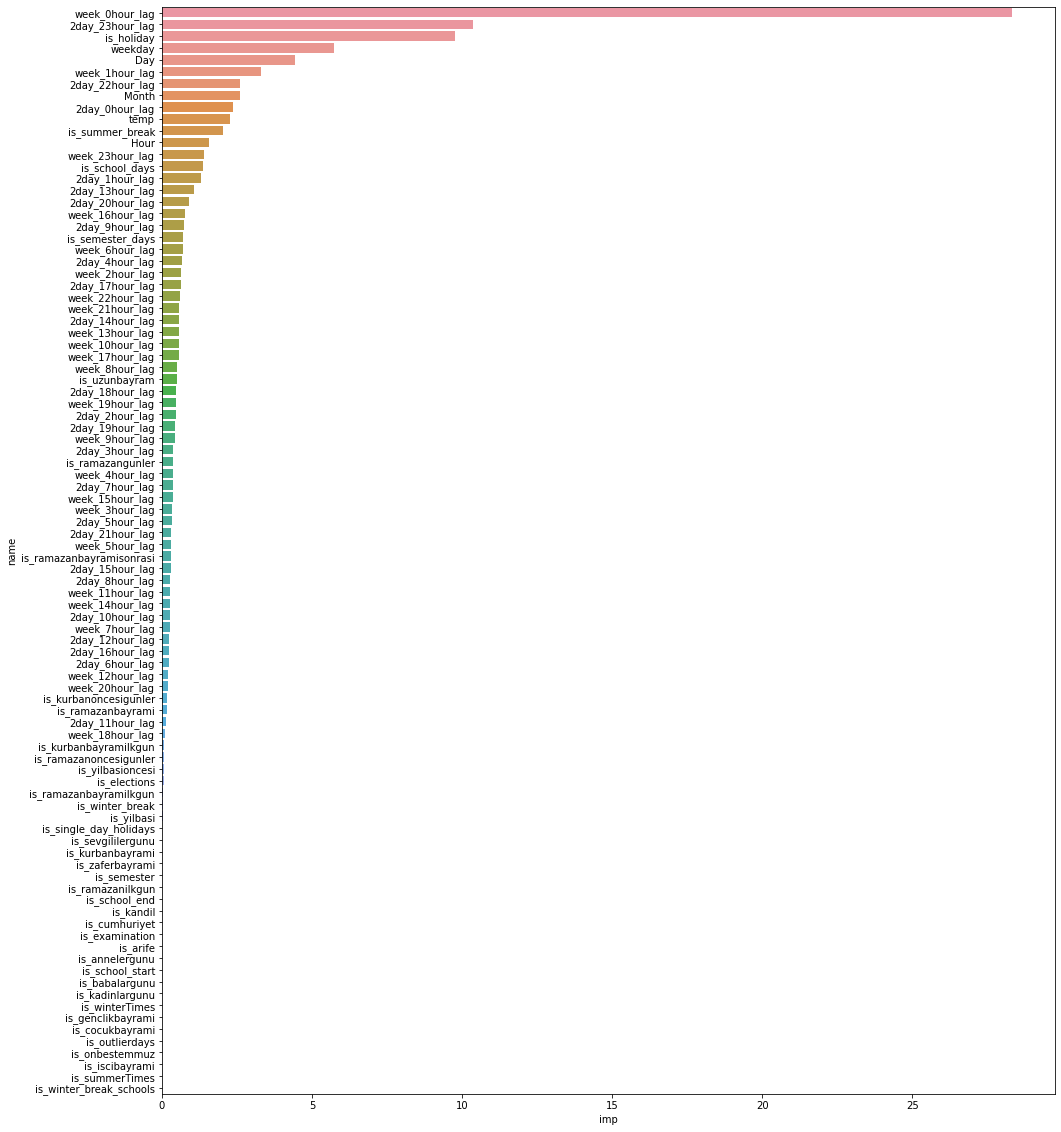

In [0]:
imp_df=pd.DataFrame()
imp_df["imp"]=model.feature_importances_
imp_df["name"]=model.feature_names_
plt.figure(figsize=(16,20))
sns.barplot(x="imp",y="name",data=imp_df.sort_values(by="imp",ascending=False))

RMSE:  1227.8813149324817
RMSLE:  0.03845547852265017
MAE:  858.265526036329
MAPE:  2.6199679513147114


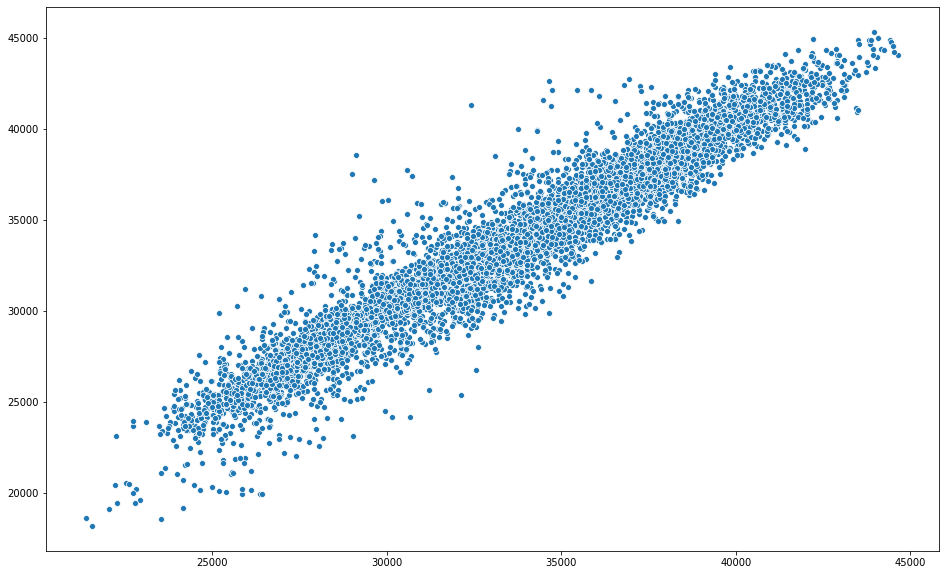

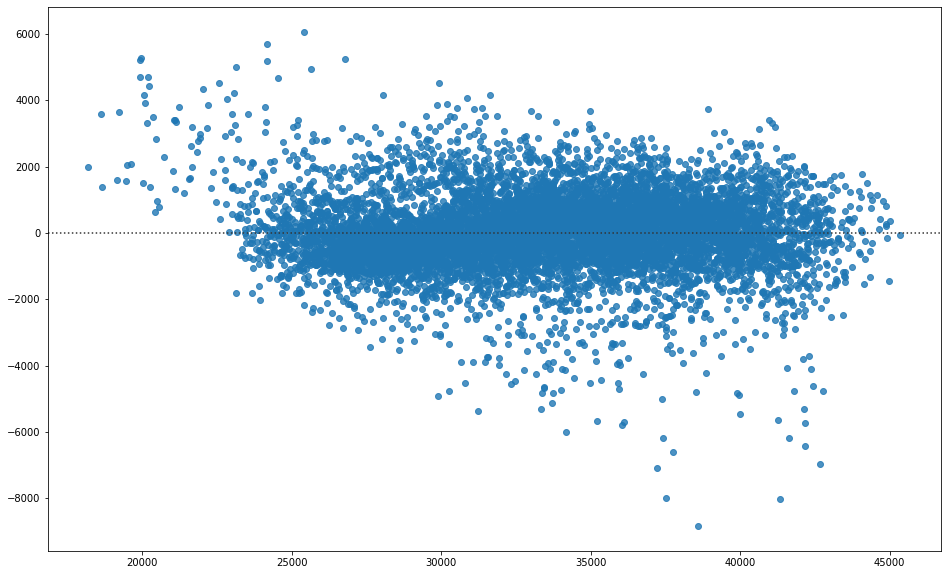

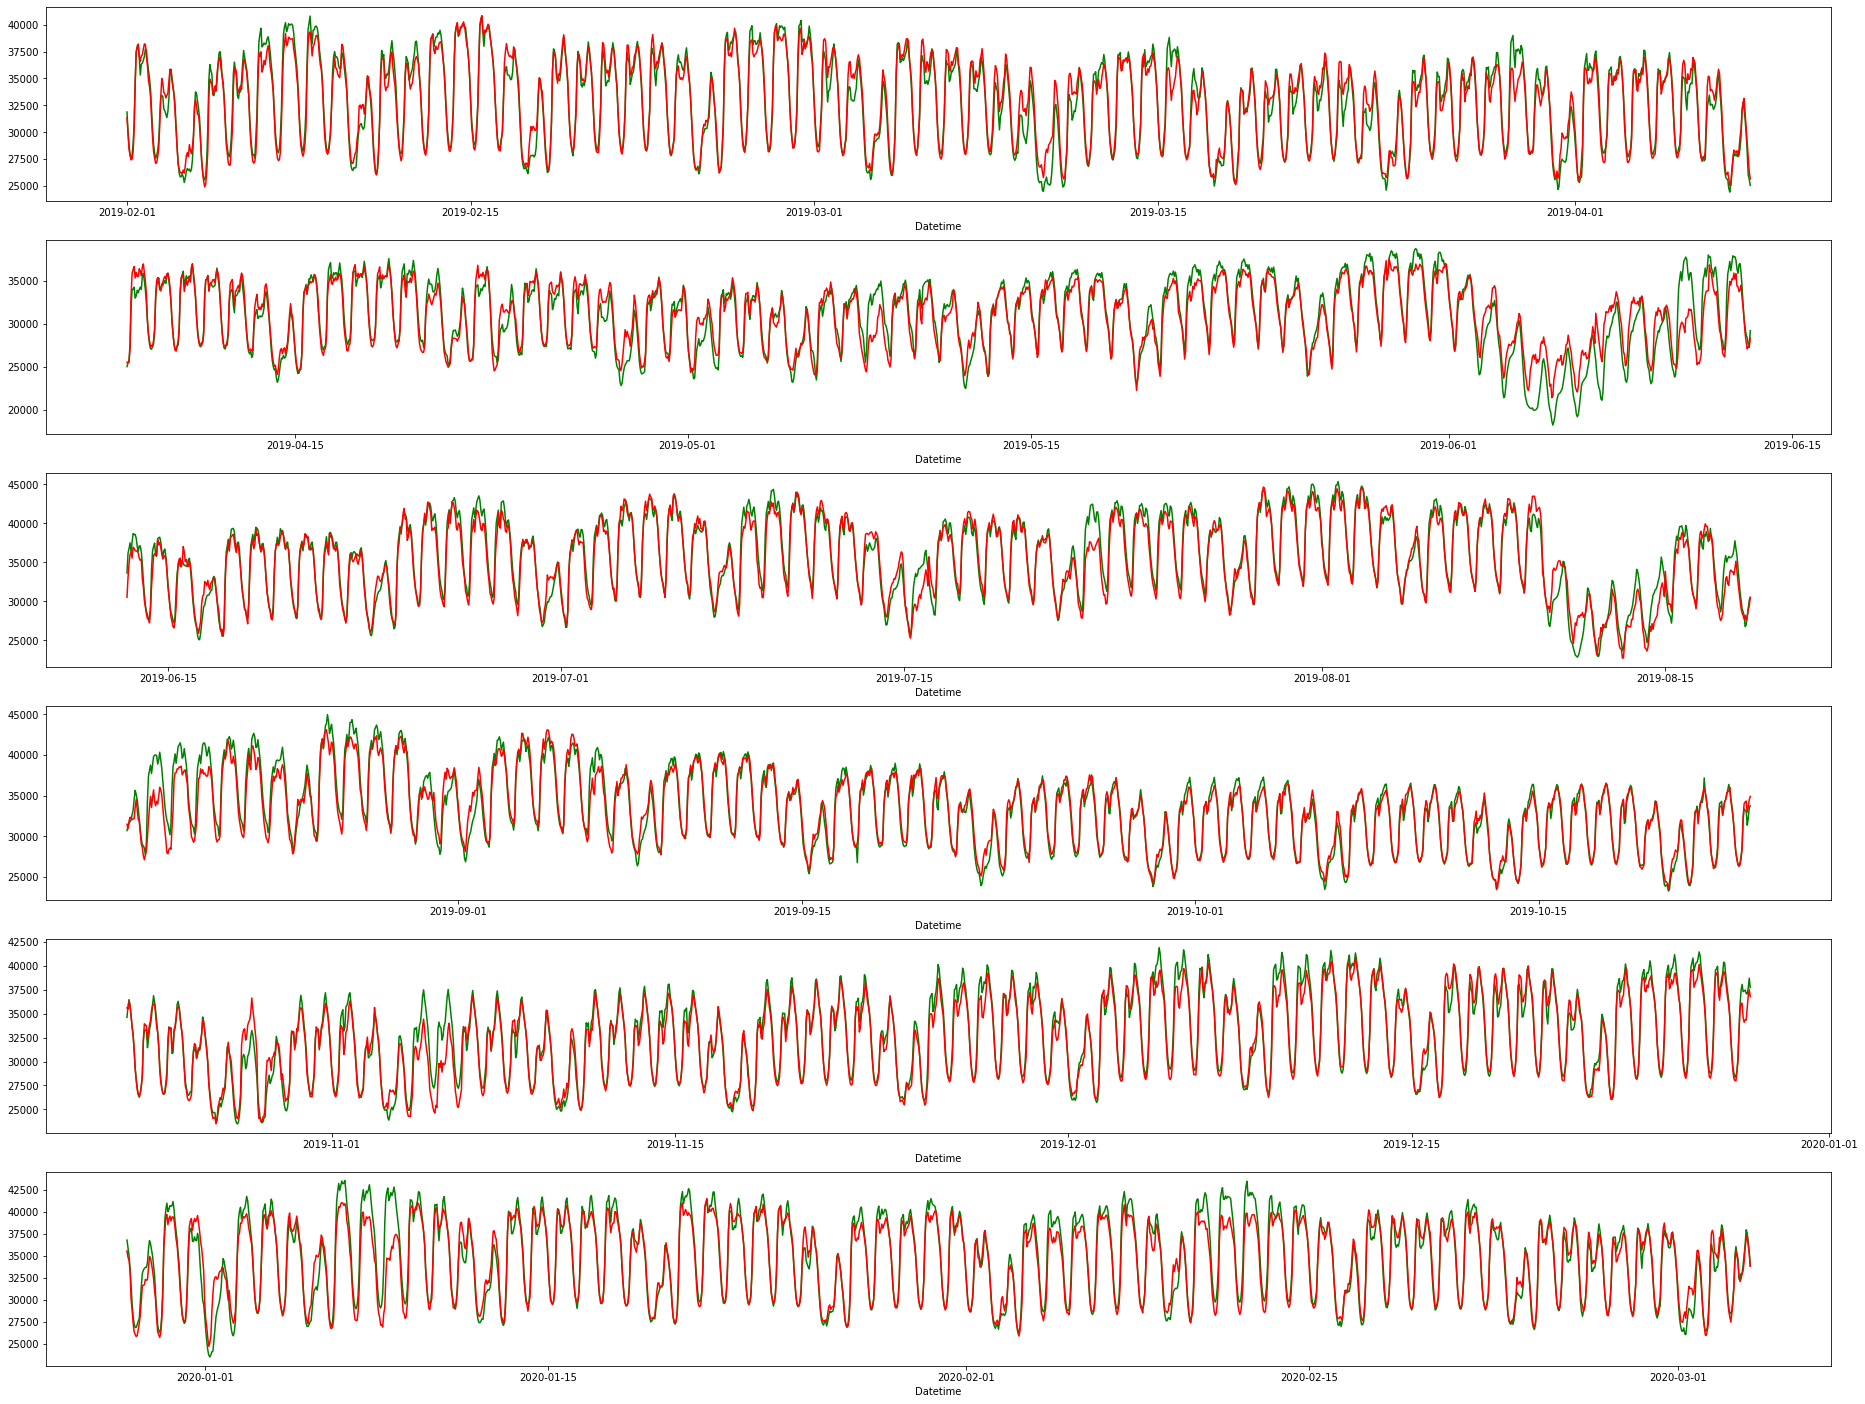

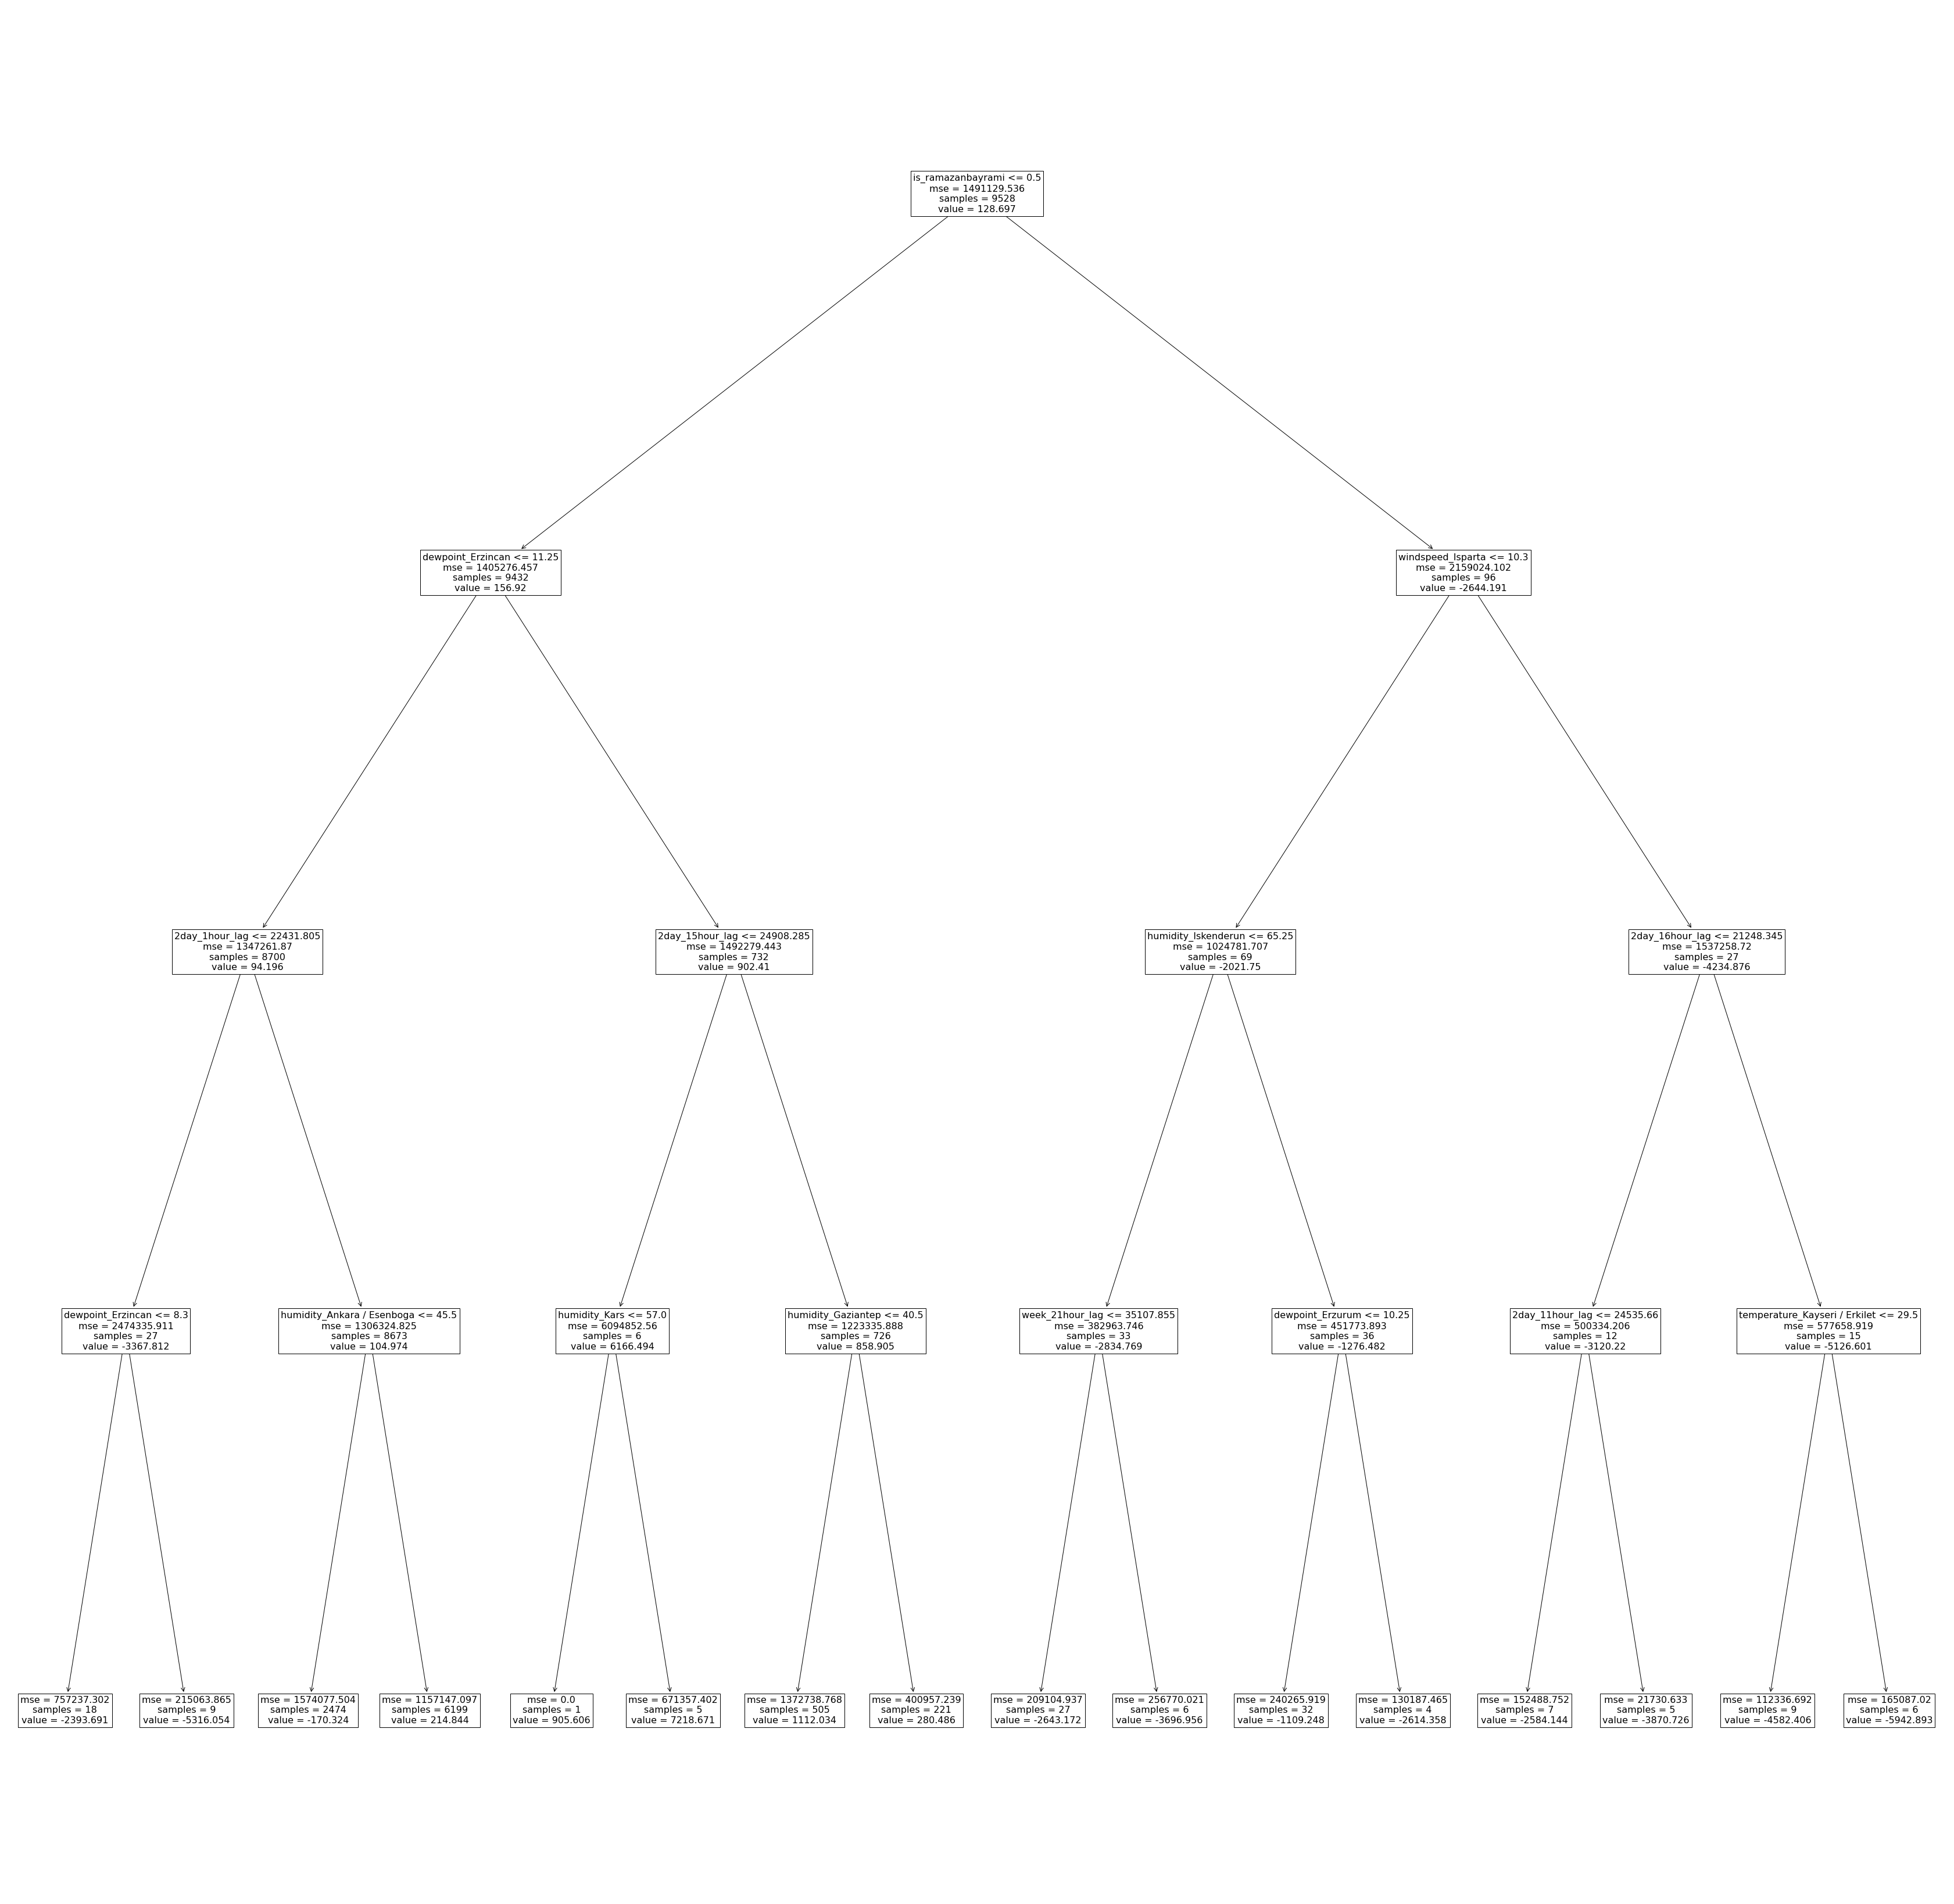

('Cat1',
 1227.8813149324817,
 0.03845547852265017,
 858.265526036329,
 2.6199679513147114)

In [0]:
y_pred=model.predict(valid_df[needed_colums])
y_true=valid_df["Consumption"].values
eval_function("Cat1",y_true,y_pred,valid_df[needed_colums.tolist()+["Datetime"]])

In [0]:
valid_df["Cat1"]=y_pred
valid_df[["Datetime","Cat1"]].to_csv("drive/My Drive/colab_datas/IE 492/kubi_preds/Cat1_24hours.csv",index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## catboost time window approach

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7-hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Date  Hour  ...  week_22hour_lag week_23hour_lag
168  07.01.2016     0  ...         28606.05        27705.82
169  07.01.2016     1  ...         27705.82        26277.24
170  07.01.2016     2  ...         26277.24        24991.82
171  07.01.2016     3  ...         24991.82        23532.61
172  07.01.2016     4  ...         23532.61        22464.78

[5 rows x 94 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor
cat_df_1=cat_df_1.loc[cat_df_1["Datetime"]>pd.to_datetime("2019-03-03 23:00:00")]
needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"])
cat_features_=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]
predictions_df={}
time_window=7*24*5 # 5 hafta time window 
pred_window=7*24
cat_df_1=cat_df_1.reset_index(drop=True)
for i in tqdm(range(time_window,len(cat_df_1)-1)):
    train_df=cat_df_1.iloc[i-time_window:i-1]
    test_df=cat_df_1.iloc[i+1:i+1+pred_window]
    model = CatBoostRegressor(learning_rate=0.05,
                                num_boost_round=100,
                                objective="MAE",
                                early_stopping_rounds=10,
                                task_type="GPU",
                                random_state=1337,
                                depth=12,
                                bootstrap_type="Poisson",
                                subsample=0.95,
                                max_bin=150)

    #eval_set=[(valid_df[needed_colums].values.tolist(),valid_df["Consumption"])]

    model.fit(train_df[needed_colums],train_df["Consumption"],
            #eval_set=eval_set,
            cat_features=[needed_colums.tolist().index(i) for i in cat_features_],
            verbose=25)
    predictions=model.predict(test_df[needed_colums])
    predictions_df[i+1,i+1+pred_window]=predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


0:	learn: 3217.5733015	total: 33.8ms	remaining: 3.35s
25:	learn: 3217.1555423	total: 720ms	remaining: 2.05s
50:	learn: 3216.7362932	total: 1.36s	remaining: 1.3s
75:	learn: 3216.3122765	total: 2s	remaining: 633ms
99:	learn: 3215.9061383	total: 2.68s	remaining: 0us
0:	learn: 3217.1361740	total: 29.9ms	remaining: 2.96s
25:	learn: 3216.7225864	total: 699ms	remaining: 1.99s
50:	learn: 3216.3069130	total: 1.35s	remaining: 1.29s
75:	learn: 3215.8867700	total: 2.02s	remaining: 638ms
99:	learn: 3215.4883790	total: 2.7s	remaining: 0us
0:	learn: 3216.6766985	total: 30.4ms	remaining: 3.01s
25:	learn: 3216.2514899	total: 658ms	remaining: 1.87s
50:	learn: 3215.8325387	total: 1.31s	remaining: 1.26s
75:	learn: 3215.4123957	total: 1.99s	remaining: 628ms
99:	learn: 3215.0187723	total: 2.67s	remaining: 0us
0:	learn: 3217.3942193	total: 30.6ms	remaining: 3.03s
25:	learn: 3216.9791418	total: 704ms	remaining: 2s
50:	learn: 3216.5610846	total: 1.38s	remaining: 1.33s
75:	learn: 3216.1430274	total: 2.09s	remai

In [0]:
predictions_df

NameError: ignored

## CatBoost unholidazasd


In [0]:
cons_unholidayized

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0      31.12.2015  00:00  ...         38.254867             0.0
1      31.12.2015  01:00  ...         38.254867             0.0
2      31.12.2015  02:00  ...         38.254867             0.0
3      31.12.2015  03:00  ...         38.254867             0.0
4      31.12.2015  04:00  ...         38.254867             0.0
...           ...    ...  ...               ...             ...
36571  03.03.2020  19:00  ...          0.000000             0.0
36572  03.03.2020  20:00  ...          0.000000             0.0
36573  03.03.2020  21:00  ...          0.000000             0.0
36574  03.03.2020  22:00  ...          0.000000             0.0
36575  03.03.2020  23:00  ...          0.000000             0.0

[36576 rows x 43 columns]

In [0]:
# cat_df_1=cons_unholidayized.copy()
# cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
# cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
# cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
# cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)
# cat_df_1["Consumption_2_lag"]=cat_df_1["Consumption"].shift(24*2)
# cat_df_1["Consumption_7_lag"]=cat_df_1["Consumption"].shift(24*7)
# cat_df_1=cat_df_1.dropna()
# cat_df_1.head()


## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_unholidayized.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7+hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Date  Hour  ...  week_22hour_lag week_23hour_lag
191  07.01.2016    23  ...     27940.432083    29745.882083
192  08.01.2016     0  ...     26671.532083    27940.432083
193  08.01.2016     1  ...     26246.622083    26671.532083
194  08.01.2016     2  ...     26026.542083    26246.622083
195  08.01.2016     3  ...     26208.842083    26026.542083

[5 rows x 246 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor

train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"]+[col for col in cat_df_1.columns if col.startswith("is")])

model = CatBoostRegressor(learning_rate=0.05,
                             num_boost_round=2000,
                             objective="RMSE",
                             early_stopping_rounds=300,
                             #task_type="GPU",
                             random_state=1337,
                             depth=12,
                             eval_metric="MAPE",
                             #bootstrap_type="Poisson",
                             subsample=0.95,
                             max_bin=150)

cat_features_= ["Day","Month","weekday","Hour"]

eval_set=[(valid_df[needed_colums],valid_df["Consumption"])]

model.fit(train_df[needed_colums],train_df["Consumption"],
          eval_set=eval_set,
          cat_features=[needed_colums.tolist().index(i) for i in cat_features_],verbose=2)

0:	learn: 0.1175947	test: 0.1107759	best: 0.1107759 (0)	total: 1.1s	remaining: 36m 36s
2:	learn: 0.1080715	test: 0.1019263	best: 0.1019263 (2)	total: 3.21s	remaining: 35m 39s
4:	learn: 0.0994890	test: 0.0940927	best: 0.0940927 (4)	total: 5.35s	remaining: 35m 34s
6:	learn: 0.0917237	test: 0.0870453	best: 0.0870453 (6)	total: 7.46s	remaining: 35m 24s
8:	learn: 0.0847042	test: 0.0806227	best: 0.0806227 (8)	total: 9.54s	remaining: 35m 10s
10:	learn: 0.0782048	test: 0.0747296	best: 0.0747296 (10)	total: 11.7s	remaining: 35m 11s
12:	learn: 0.0724534	test: 0.0694706	best: 0.0694706 (12)	total: 13.8s	remaining: 35m 7s
14:	learn: 0.0673703	test: 0.0649930	best: 0.0649930 (14)	total: 15.9s	remaining: 35m 3s
16:	learn: 0.0627091	test: 0.0608348	best: 0.0608348 (16)	total: 18s	remaining: 34m 57s
18:	learn: 0.0586021	test: 0.0573410	best: 0.0573410 (18)	total: 20.1s	remaining: 34m 51s
20:	learn: 0.0548000	test: 0.0540715	best: 0.0540715 (20)	total: 22.2s	remaining: 34m 52s
22:	learn: 0.0514001	test

RMSE:  1356.211116132582
RMSLE:  0.04121365796335193
MAE:  968.2004773419162
MAPE:  2.9016612439649294


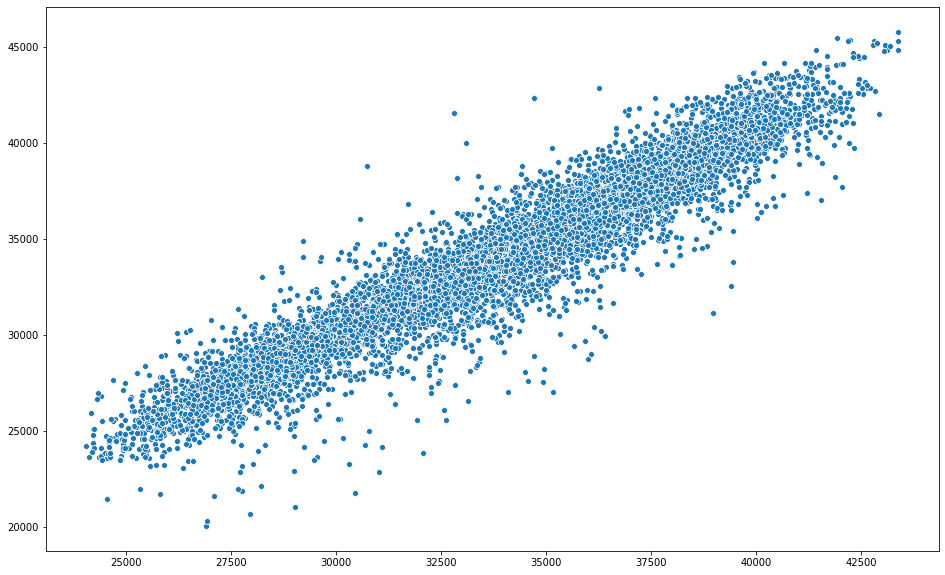

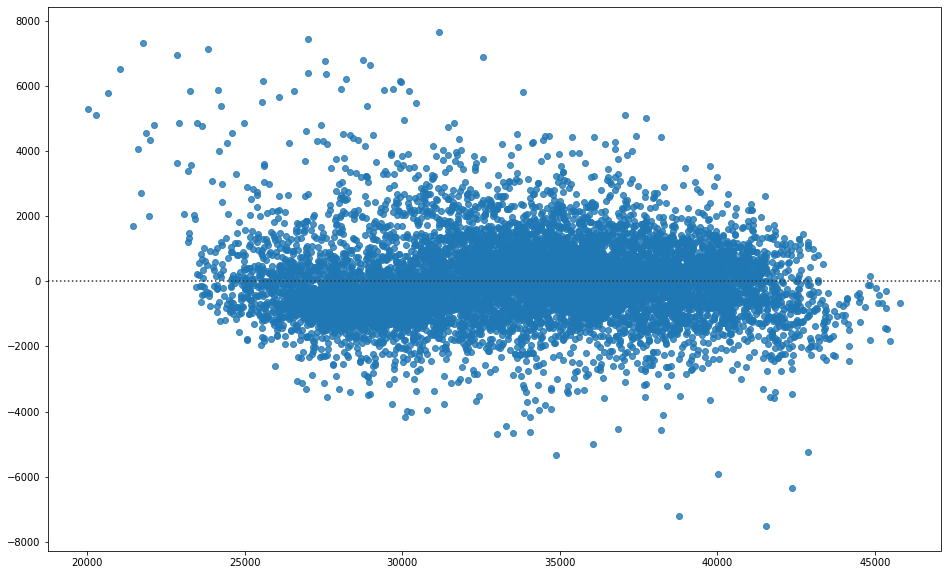

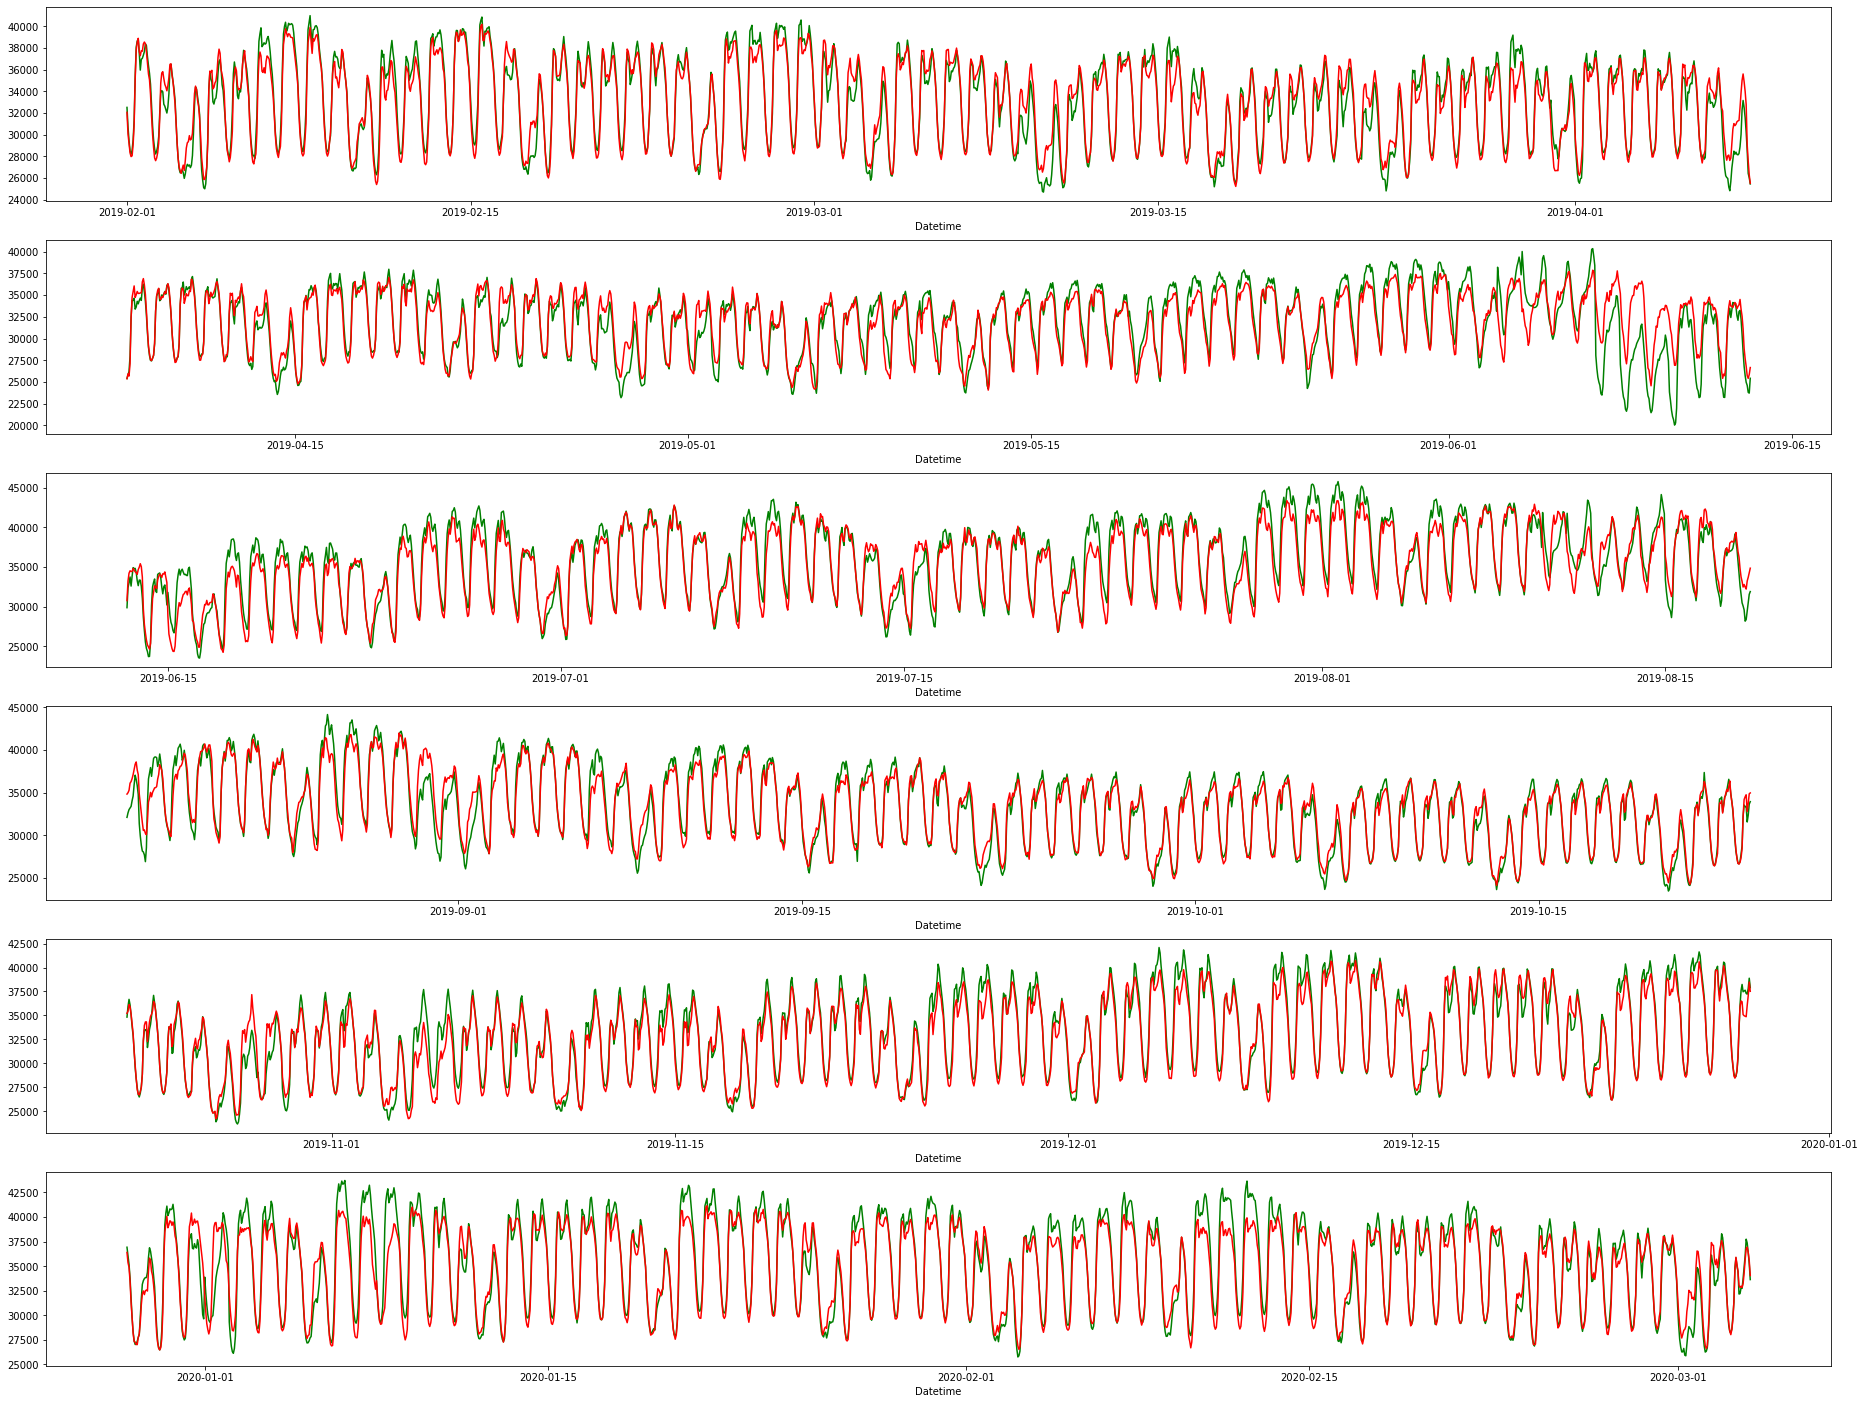

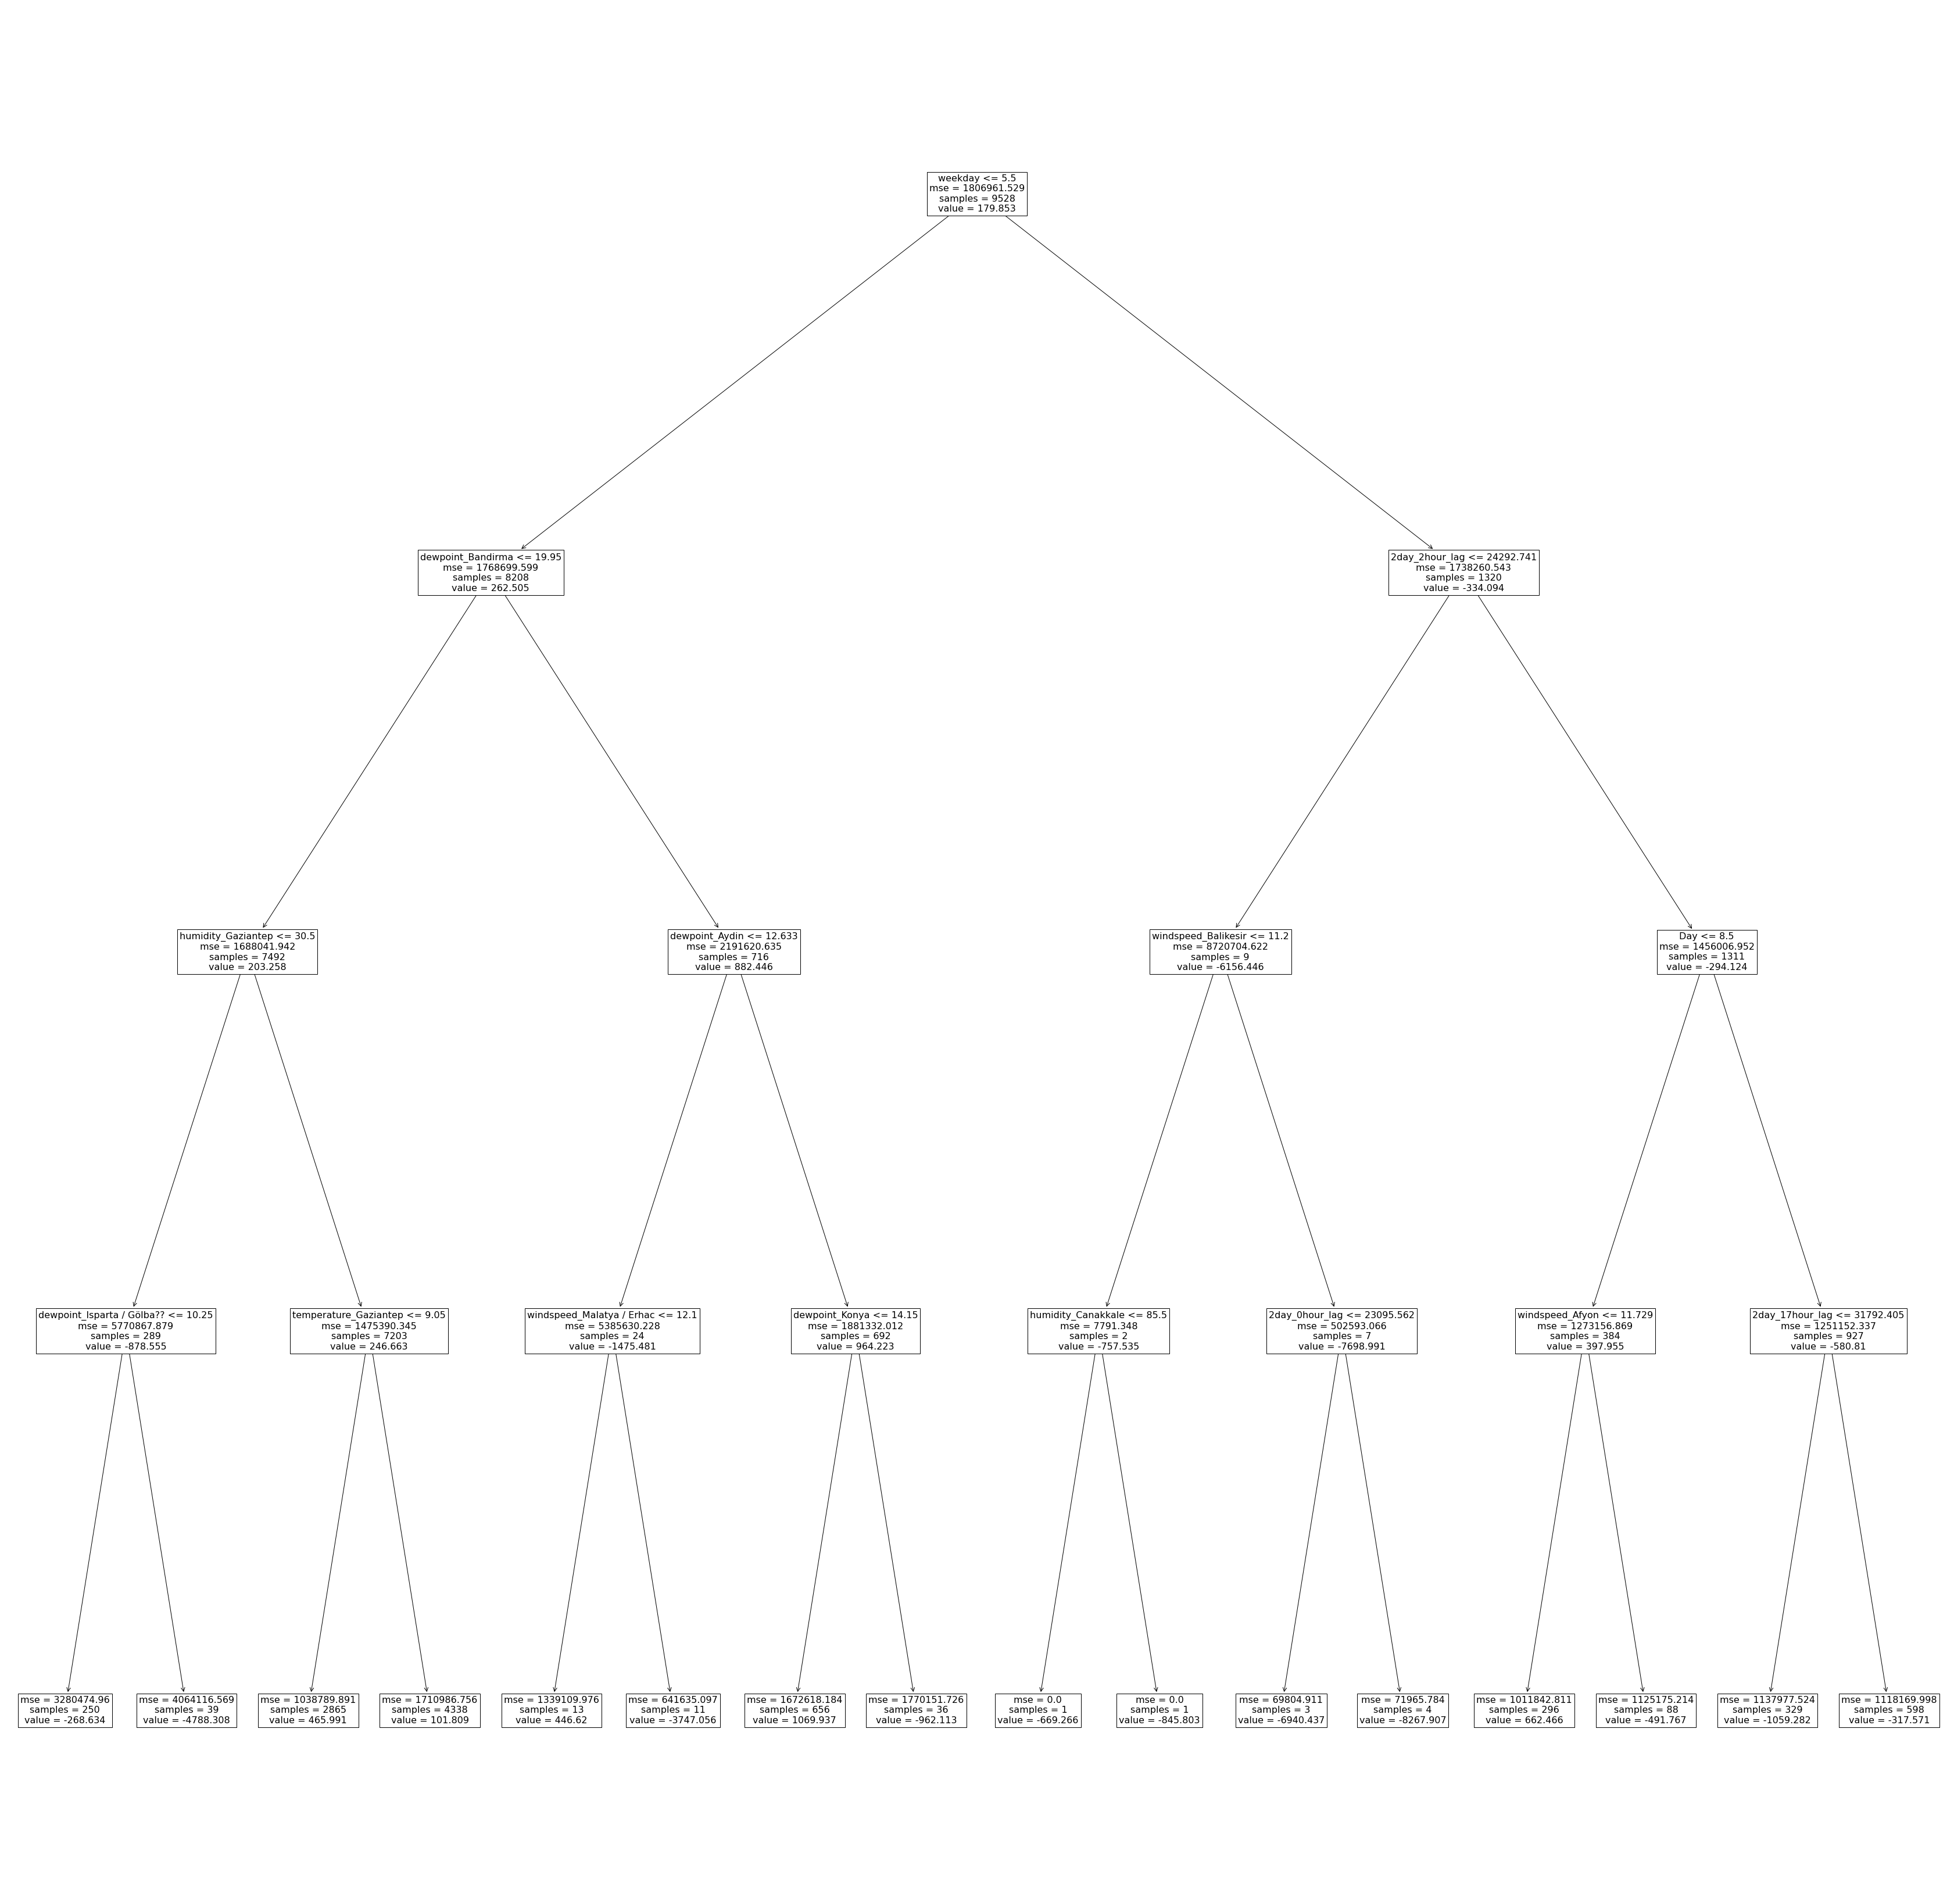

('Cat2',
 1356.211116132582,
 0.04121365796335193,
 968.2004773419162,
 2.9016612439649294)

In [0]:
y_pred=model.predict(valid_df[needed_colums])
y_true=valid_df["Consumption"].values
eval_function("Cat2",y_true,y_pred,valid_df[needed_colums.tolist()+["Datetime"]])

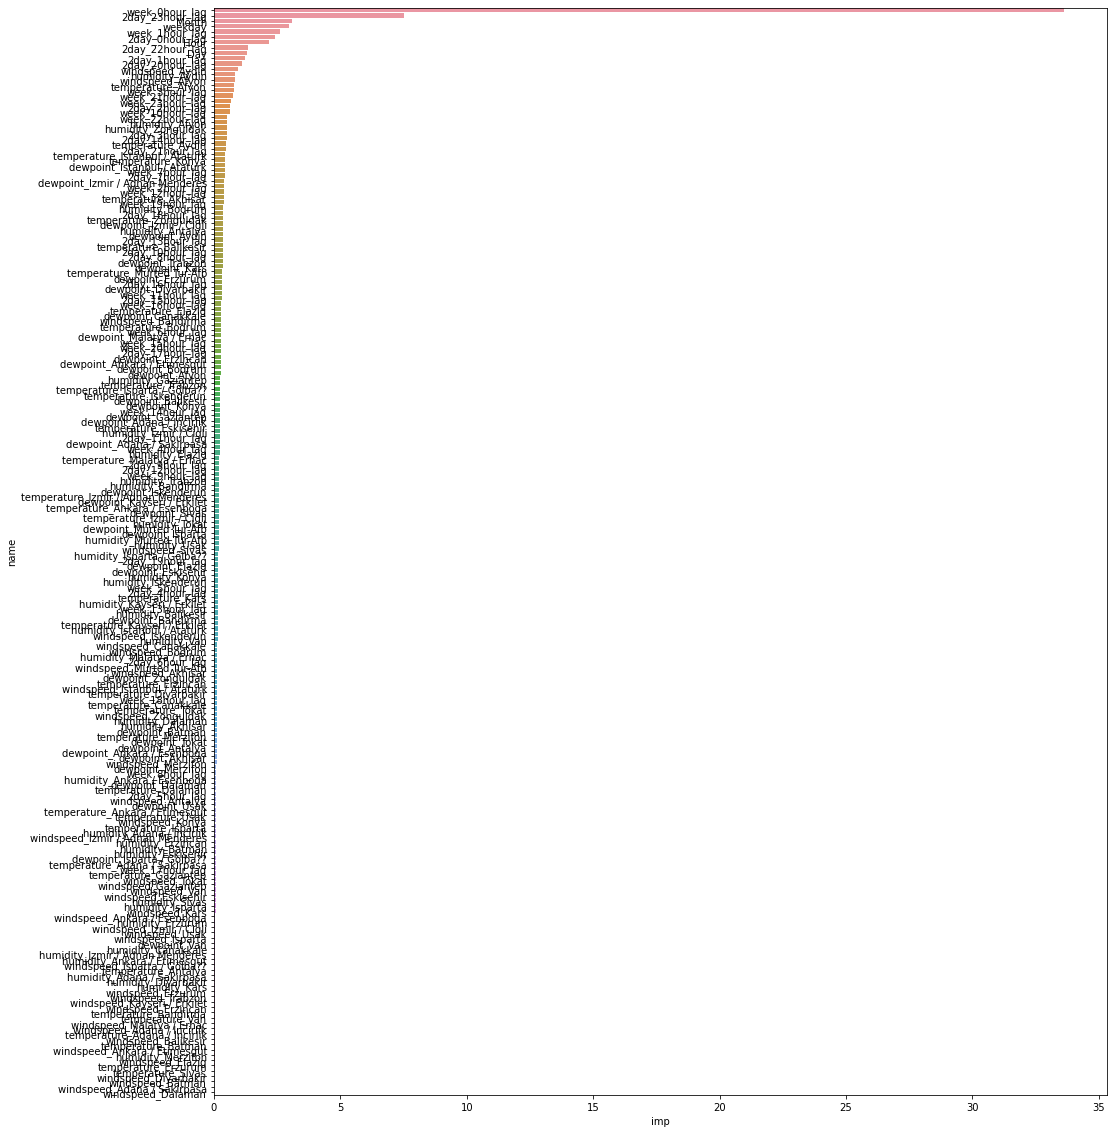

In [0]:
imp_df=pd.DataFrame()
imp_df["imp"]=model.feature_importances_
imp_df["name"]=model.feature_names_
plt.figure(figsize=(16,20))
sns.barplot(x="imp",y="name",data=imp_df.sort_values(by="imp",ascending=False))

In [0]:
y_pred

array([32058.50853464, 30058.69933922, 29176.55234564, ...,
       36396.55201455, 35551.05691401, 34049.09739391])

In [0]:
valid_df["Cat2_categorical"]=y_pred+valid_df[[i for i in valid_df.columns if i.startswith("is")]].sum(axis=1).values
valid_df[["Datetime","Cat2_categorical"]].to_csv("drive/My Drive/colab_datas/IE 492/kubi_preds/Cat2_categorical_24hours.csv",index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Keras

### Data fix for keras

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)
# # hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2+hour)

# # week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7+hour)


#for day_before in [2,7,7*2,7*3,7*4]:
#    for hour in range(24):
#        cat_df_1["conv_{}_day_{}_hour_lag".format(day_before,hour)]=cat_df_1["Consumption"].shift(day_before*24+hour)


cat_df_1=cat_df_1.dropna()
cat_df_1=cat_df_1.reset_index(drop=True)
cat_df_1

Datetime        Date  ...  week_22hour_lag  week_23hour_lag
0     2016-01-07 23:00:00  07.01.2016  ...         27785.43         29590.88
1     2016-01-08 00:00:00  08.01.2016  ...         26516.53         27785.43
2     2016-01-08 01:00:00  08.01.2016  ...         26091.62         26516.53
3     2016-01-08 02:00:00  08.01.2016  ...         25871.54         26091.62
4     2016-01-08 03:00:00  08.01.2016  ...         26053.84         25871.54
...                   ...         ...  ...              ...              ...
36380 2020-03-03 19:00:00  03.03.2020  ...         37548.92         38806.87
36381 2020-03-03 20:00:00  03.03.2020  ...         36354.90         37548.92
36382 2020-03-03 21:00:00  03.03.2020  ...         34667.80         36354.90
36383 2020-03-03 22:00:00  03.03.2020  ...         32620.14         34667.80
36384 2020-03-03 23:00:00  03.03.2020  ...         30908.55         32620.14

[36385 rows x 95 columns]

In [0]:
train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

In [0]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# cat_features=["Day","Month","weekday","Hour"]

# y_train

# linear_enc=OneHotEncoder()
# one_hot_encoded=linear_enc.fit_transform(cat_df_1[cat_features]).toarray()
# train_df=hstack([cat_df_1[cat_df_1.columns.difference(cat_features)].drop(columns=["Consumption","Date","Datetime"]).astype(float),one_hot_encoded])
## dataframe cevirip hallet
# cat_features

### modellnig

In [0]:

!pip install --upgrade keras

from keras import backend as K
import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Cropping2D,Lambda,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D,LSTM
from keras.models import Sequential,Model

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
# from keras.applications.densenet import DenseNet121, preprocess_input
from keras.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from keras.optimizers import Adam, SGD, rmsprop

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(mean_squared_log_error(y_true.toarray(), y_pred.toarray()))

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
            EarlyStopping(patience=15, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
            ]

#### *lstm*

In [0]:
time_series_df=cons_holiday_binary[["Datetime","Consumption"]]
for hour in tqdm(range(7*24)):
    time_series_df["week_{}hour_lag".format(hour)]=time_series_df["Consumption"].shift(hour)
time_series_df["Consumption_pred"]=time_series_df["Consumption"].shift(7*24+36)
time_series_df.dropna(inplace=True)
time_series_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Datetime  Consumption  ...  week_167hour_lag  Consumption_pred
204   2016-01-08 12:00:00     34622.56  ...          29367.70          29590.88
205   2016-01-08 13:00:00     36134.82  ...          29548.32          27785.43
206   2016-01-08 14:00:00     36555.58  ...          29390.89          26516.53
207   2016-01-08 15:00:00     36190.41  ...          30734.97          26091.62
208   2016-01-08 16:00:00     37031.72  ...          32048.02          25871.54
...                   ...          ...  ...               ...               ...
36571 2020-03-03 19:00:00     37936.79  ...          38791.40          31320.65
36572 2020-03-03 20:00:00     37553.37  ...          37588.86          36416.24
36573 2020-03-03 21:00:00     36581.73  ...          36290.64          38922.74
36574 2020-03-03 22:00:00     35434.36  ...          34580.08          38599.55
36575 2020-03-03 23:00:00     33827.00  ...          32433.27          38621.87

[36372 rows x 171 columns]

In [0]:
# univariate stacked lstm example
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

n_steps = 7*24+1
# split into samples
train_df=time_series_df.loc[time_series_df["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=time_series_df.loc[time_series_df["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]
X, y = train_df[train_df.columns.difference(("Datetime","Consumption_pred"))].values,train_df["Consumption_pred"].values
X_test, y_test = valid_df[valid_df.columns.difference(("Datetime","Consumption_pred"))].values,valid_df["Consumption_pred"].values

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
# define model
X,y

(array([[[34622.56],
         [34622.56],
         [32982.07],
         ...,
         [38606.67],
         [37175.84],
         [25315.55]],
 
        [[36134.82],
         [36134.82],
         [37175.84],
         ...,
         [39659.57],
         [38606.67],
         [25128.15]],
 
        [[36555.58],
         [36555.58],
         [38606.67],
         ...,
         [38416.32],
         [39659.57],
         [25356.22]],
 
        ...,
 
        [[35952.69],
         [35952.69],
         [31358.46],
         ...,
         [33563.93],
         [33107.33],
         [37335.81]],
 
        [[35100.36],
         [35100.36],
         [33107.33],
         ...,
         [32931.3 ],
         [33563.93],
         [37666.45]],
 
        [[34013.42],
         [34013.42],
         [33563.93],
         ...,
         [32145.48],
         [32931.3 ],
         [38337.17]]]),
 array([29590.88, 27785.43, 26516.53, ..., 38000.64, 38436.01, 38457.42]))

In [0]:
model = Sequential()
model.add(LSTM(450, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(250, activation='relu', return_sequences=True))
model.add(LSTM(150, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss=mean_absolute_percentage_error, metrics=[mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,
                                                                                                #  root_mean_squared_log_error
                                                                                                 ])
# fit model
history=model.fit(X, y, batch_size=100, epochs=200, validation_data=(X_test,y_test))


Train on 26844 samples, validate on 9528 samples
Epoch 1/200
26844/26844 [==============================] - 388s 14ms/step - loss: 312097.6724 - mean_absolute_error: 101390992.0000 - mean_absolute_percentage_error: 312097.6562 - root_mean_squared_error: 313724096.0000 - val_loss: 172614.6837 - val_mean_absolute_error: 56797744.0000 - val_mean_absolute_percentage_error: 172614.6562 - val_root_mean_squared_error: 122323880.0000
Epoch 2/200
26844/26844 [==============================] - 395s 15ms/step - loss: 41405.9215 - mean_absolute_error: 13232591.0000 - mean_absolute_percentage_error: 41405.9219 - root_mean_squared_error: 31827606.0000 - val_loss: 9298.5757 - val_mean_absolute_error: 3010606.5000 - val_mean_absolute_percentage_error: 9298.5771 - val_root_mean_squared_error: 9036233.0000
Epoch 3/200
26844/26844 [==============================] - 397s 15ms/step - loss: 17112.6625 - mean_absolute_error: 5493927.5000 - mean_absolute_percentage_error: 17112.6562 - root_mean_squared_error:

KeyboardInterrupt: ignored

#### lstm yalandan

array([31092.87, 28602.02, 27112.37, ..., 35952.69, 35100.36, 34013.42])

In [0]:
# basic dense model
from keras.models import Model
from keras.layers import Input, Dense,Concatenate
import tensorflow as tf

model = Sequential()
model.add(LSTM(250, activation='relu', return_sequences=True, input_shape=(1, train_df.drop(columns=["Date","Datetime","Consumption"]).shape[1])))
model.add(LSTM(150, activation='relu', return_sequences=True,))
model.add(Dropout(0.3))
model.add(LSTM(150, activation='relu', return_sequences=True,))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1))
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 1, 250)            494000    
_________________________________________________________________
lstm_66 (LSTM)               (None, 1, 150)            240600    
_________________________________________________________________
dropout_13 (Dropout)         (None, 1, 150)            0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 1, 150)            180600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 150)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               77312     
_________________________________________________________________
dense_41 (Dense)             (None, 1)               

In [0]:
model.input_shape,train_df.drop(columns=["Date","Datetime","Consumption"]).values.reshape(26857,1,243).shape,valid_df.drop(columns=["Date","Datetime","Consumption"]).values.reshape(9528,1,243).shape

((None, 1, 243), (26857, 1, 243), (9528, 1, 243))

In [0]:
valid_df.columns.difference(train_df.columns)

Index(['Keras_Basic_dense_48'], dtype='object')

#### *basic dense* **bold text**

In [0]:
# basic dense model
from keras.models import Model
from keras.layers import Input, Dense

a = Input(shape=(train_df.drop(columns=["Date","Datetime","Consumption"]).shape[1],))
d = Dense(1024, activation='relu')(a)
c = Dense(512, activation='relu')(d)
output_layer=Dense(1)(c)
model = Model(inputs=a, outputs=output_layer)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 92)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              95232     
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 620,545
Trainable params: 620,545
Non-trainable params: 0
_________________________________________________________________


### train part

In [0]:
model.compile(optimizer=Adam(lr=1e-3, decay=1e-9), loss=mean_absolute_percentage_error, metrics=[mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error])
history=model.fit(train_df.drop(columns=["Date","Datetime","Consumption"]),train_df["Consumption"],batch_size=24,epochs=250,validation_data=(valid_df.drop(columns=["Date","Datetime","Consumption"]),valid_df["Consumption"]))
# 250 epoch weathersiz mape:

Train on 26857 samples, validate on 9528 samples
Epoch 1/250
26857/26857 [==============================] - 6s 226us/step - loss: 6.7504 - mean_absolute_error: 2143.9177 - mean_absolute_percentage_error: 6.7504 - root_mean_squared_error: 2864.4263 - val_loss: 5.1189 - val_mean_absolute_error: 1659.3135 - val_mean_absolute_percentage_error: 5.1189 - val_root_mean_squared_error: 1895.4808
Epoch 2/250
26857/26857 [==============================] - 4s 160us/step - loss: 5.3274 - mean_absolute_error: 1684.9011 - mean_absolute_percentage_error: 5.3274 - root_mean_squared_error: 2431.7659 - val_loss: 5.4079 - val_mean_absolute_error: 1718.7161 - val_mean_absolute_percentage_error: 5.4079 - val_root_mean_squared_error: 1933.8722
Epoch 3/250
26857/26857 [==============================] - 4s 153us/step - loss: 5.1272 - mean_absolute_error: 1626.3704 - mean_absolute_percentage_error: 5.1272 - root_mean_squared_error: 2353.5632 - val_loss: 4.9430 - val_mean_absolute_error: 1630.2406 - val_mean_abs

In [0]:
3.7493
3.6831-weather

In [0]:
y_pred=model.predict(valid_df.drop(columns=["Date","Datetime","Consumption"])).reshape((1,-1))[0]
y_true=valid_df["Consumption"].values
eval_function("Keras",y_true,y_pred,valid_df.drop(columns=["Date","Consumption"]))

In [0]:
valid_df["Keras_Basic_dense_48"]=y_pred
valid_df[["Datetime","Keras_Basic_dense_48"]].to_csv("drive/My Drive/colab_datas/IE 492/kubi_preds/Keras_Basic_dense_48.csv",index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# LSTM

### Data fix for keras

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)
# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7-hour)

#for day_before in [2,7,7*2,7*3,7*4]:
#   for hour in range(24):
#        cat_df_1["conv_{}_day_{}_hour_lag".format(day_before,hour)]=cat_df_1["Consumption"].shift(day_before+hour)


cat_df_1=cat_df_1.dropna()
cat_df_1=cat_df_1.reset_index(drop=True)
cat_df_1

Date  Hour  ...  conv_28_day_22_hour_lag conv_28_day_23_hour_lag
0      02.01.2016     3  ...                 27785.43                29590.88
1      02.01.2016     4  ...                 26516.53                27785.43
2      02.01.2016     5  ...                 26091.62                26516.53
3      02.01.2016     6  ...                 25871.54                26091.62
4      02.01.2016     7  ...                 26053.84                25871.54
...           ...   ...  ...                      ...                     ...
36520  03.03.2020    19  ...                 30076.93                28485.01
36521  03.03.2020    20  ...                 32545.38                30076.93
36522  03.03.2020    21  ...                 35049.21                32545.38
36523  03.03.2020    22  ...                 34901.84                35049.21
36524  03.03.2020    23  ...                 34225.14                34901.84

[36525 rows x 166 columns]

In [0]:
train_df=cat_df_1.loc[cat_df_1["Datetime"]<pd.to_datetime("2019-02-01 00:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")]

In [0]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

cat_features=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]

# y_train

# linear_enc=OneHotEncoder()
# one_hot_encoded=linear_enc.fit_transform(cat_df_1[cat_features]).toarray()
# train_df=hstack([cat_df_1[cat_df_1.columns.difference(cat_features)].drop(columns=["Consumption","Date","Datetime"]).astype(float),one_hot_encoded])
# ## dataframe cevirip hallet
cat_features

['is_annelergunu',
 'is_arife',
 'is_babalargunu',
 'is_cocukbayrami',
 'is_cumhuriyet',
 'is_elections',
 'is_examination',
 'is_genclikbayrami',
 'is_holiday',
 'is_iscibayrami',
 'is_kadinlargunu',
 'is_kandil',
 'is_kurbanbayrami',
 'is_kurbanbayramilkgun',
 'is_kurbanoncesigunler',
 'is_onbestemmuz',
 'is_outlierdays',
 'is_ramazanbayrami',
 'is_ramazanbayramilkgun',
 'is_ramazanbayramisonrasi',
 'is_ramazangunler',
 'is_ramazanilkgun',
 'is_ramazanoncesigunler',
 'is_school_days',
 'is_school_end',
 'is_school_start',
 'is_semester',
 'is_semester_days',
 'is_sevgililergunu',
 'is_single_day_holidays',
 'is_summerTimes',
 'is_summer_break',
 'is_uzunbayram',
 'is_winterTimes',
 'is_winter_break',
 'is_winter_break_schools',
 'is_yilbasi',
 'is_yilbasioncesi',
 'is_zaferbayrami']

In [0]:
def fix_df_lstm(cat_df_1):
    dense_part=cat_df_1[[i for i in cat_df_1.columns if not i.startswith("conv") and not i.startswith("Date")]].copy().drop(columns=["Consumption"])
    label=cat_df_1["Consumption"]
    lag_part=cat_df_1[[i for i in cat_df_1.columns if i.startswith("conv")]]
    conv_means=[]
    conv_vars=[]
    for row in tqdm(lag_part.values):
        conv_means.append([np.mean([np.full(len(row),val_),row],axis=0) for val_ in row])
        conv_vars.append([np.var([np.full(len(row),val_),row],axis=0) for val_ in row])
    conv_means=np.array(conv_means)
    conv_means=conv_means.reshape(list(conv_means.shape)+[1])
    conv_vars=np.array(conv_vars)
    conv_vars=conv_vars.reshape(list(conv_vars.shape)+[1])
    return dense_part,conv_means,conv_vars,label

In [0]:
dense_part,conv_means,conv_vars,label=fix_df_lstm(train_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


### modellnig

In [0]:
!pip install --upgrade keras

from keras import backend as K
import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Cropping2D,Lambda,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D,LSTM
from keras.models import Sequential,Model

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


Using TensorFlow backend.


In [0]:
# from keras.applications.densenet import DenseNet121, preprocess_input
from keras.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from keras.optimizers import Adam, SGD, rmsprop

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(mean_squared_log_error(y_true.toarray(), y_pred.toarray()))

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
            EarlyStopping(patience=15, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
            ]

In [0]:
# basic dense model
from keras.models import Model
from keras.layers import Input, Dense,Concatenate

flat_input = Input(shape=(43,))
mean_input = Input(shape=(120,120,1))
var_input = Input(shape=(120,120,1))

## mean_part

conv_1=Conv2D(48, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(mean_input)
maxp_1=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_1)
conv_2=Conv2D(24, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(maxp_1)
maxp_2=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_2)
flatt_mean=Flatten()(maxp_2)

## variance_part

conv_1=Conv2D(48, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(var_input)
maxp_1=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_1)
conv_2=Conv2D(24, kernel_size=(12, 12), strides=(1, 1),
                 activation='relu')(maxp_1)
maxp_2=MaxPooling2D(pool_size=(6, 6), strides=(2, 2))(conv_2)
flatt_var=Flatten()(maxp_2)

## flat input

concat = Concatenate()([flatt_mean, flatt_var,flat_input])

mid_dense = Dense(1024, activation='relu')(concat)
drop_1=Dropout(0.3)(mid_dense)
lstm_1=LSTM(500, activation='relu',input_shape=(1,1))(drop_1)
lstm_2=LSTM(250, activation='relu')(lstm_1)
drop_2=Dropout(0.3)(lstm_2)
lstm_3=LSTM(250, activation='relu')(drop_2)
mid_dense_1 = Dense(512, activation='relu')(lstm_3)
output_layer = Dense(1)(mid_dense_1)
model=Model(inputs=[mean_input, var_input, flat_input], outputs=output_layer)
model.summary()

Using TensorFlow backend.


NameError: ignored

In [0]:
valid_dense_part,valid_conv_means,valid_conv_vars,valid_label=fix_df_lstm(valid_df)

In [0]:
model.compile(optimizer=Adam(lr=1e-2, decay=1e-7), loss=mean_absolute_percentage_error, metrics=[mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error,
                                                                                                #  root_mean_squared_log_error
                                                                                                 ])
model.fit([conv_means,conv_vars,dense_part],label,validation_data=([valid_conv_means,valid_conv_vars,valid_dense_part],valid_label),epochs=1000,batch_size=200)

Train on 26997 samples, validate on 9528 samples
Epoch 1/1000
26997/26997 [==============================] - 21s 779us/step - loss: 28.8994 - mean_absolute_error: 9395.4014 - mean_absolute_percentage_error: 28.8994 - root_mean_squared_error: 10265.8564 - val_loss: 9.7129 - val_mean_absolute_error: 3360.6670 - val_mean_absolute_percentage_error: 9.7129 - val_root_mean_squared_error: 4050.8098
Epoch 2/1000
26997/26997 [==============================] - 21s 774us/step - loss: 9.7791 - mean_absolute_error: 3201.7773 - mean_absolute_percentage_error: 9.7791 - root_mean_squared_error: 4011.4829 - val_loss: 8.3396 - val_mean_absolute_error: 2823.8621 - val_mean_absolute_percentage_error: 8.3396 - val_root_mean_squared_error: 3450.4492
Epoch 3/1000
26997/26997 [==============================] - 21s 771us/step - loss: 9.4215 - mean_absolute_error: 3082.9663 - mean_absolute_percentage_error: 9.4215 - root_mean_squared_error: 3829.9722 - val_loss: 9.5171 - val_mean_absolute_error: 3311.5371 - val

KeyboardInterrupt: ignored

RMSE:  1988.4382
RMSLE:  0.062285724558912334
MAE:  tf.Tensor(1248.1774, shape=(), dtype=float32)
MAPE:  tf.Tensor(3.8238955, shape=(), dtype=float32)


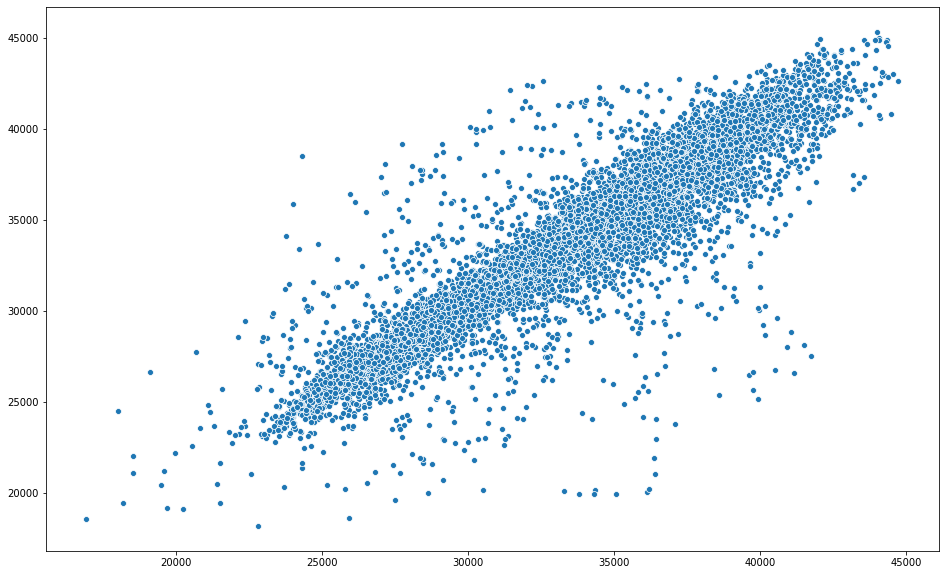

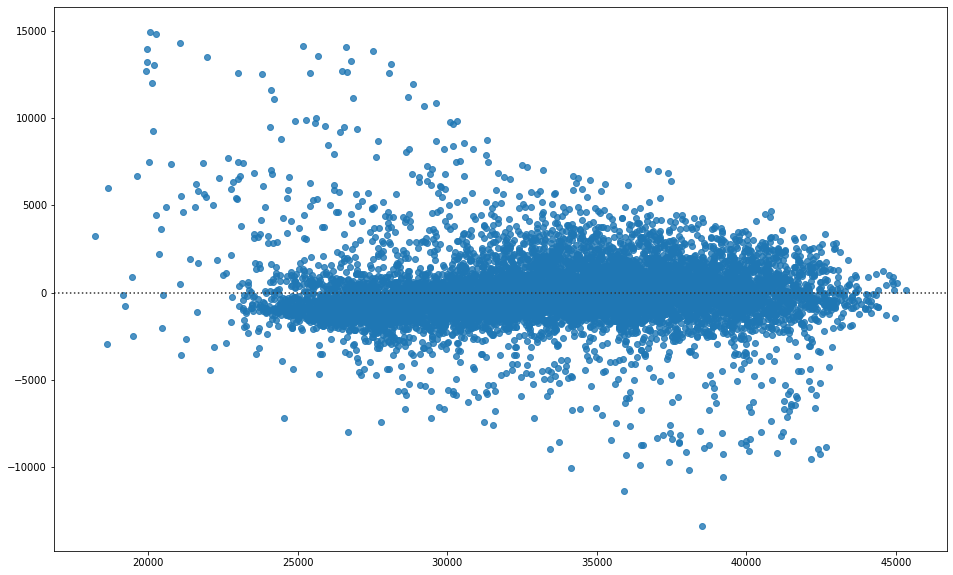

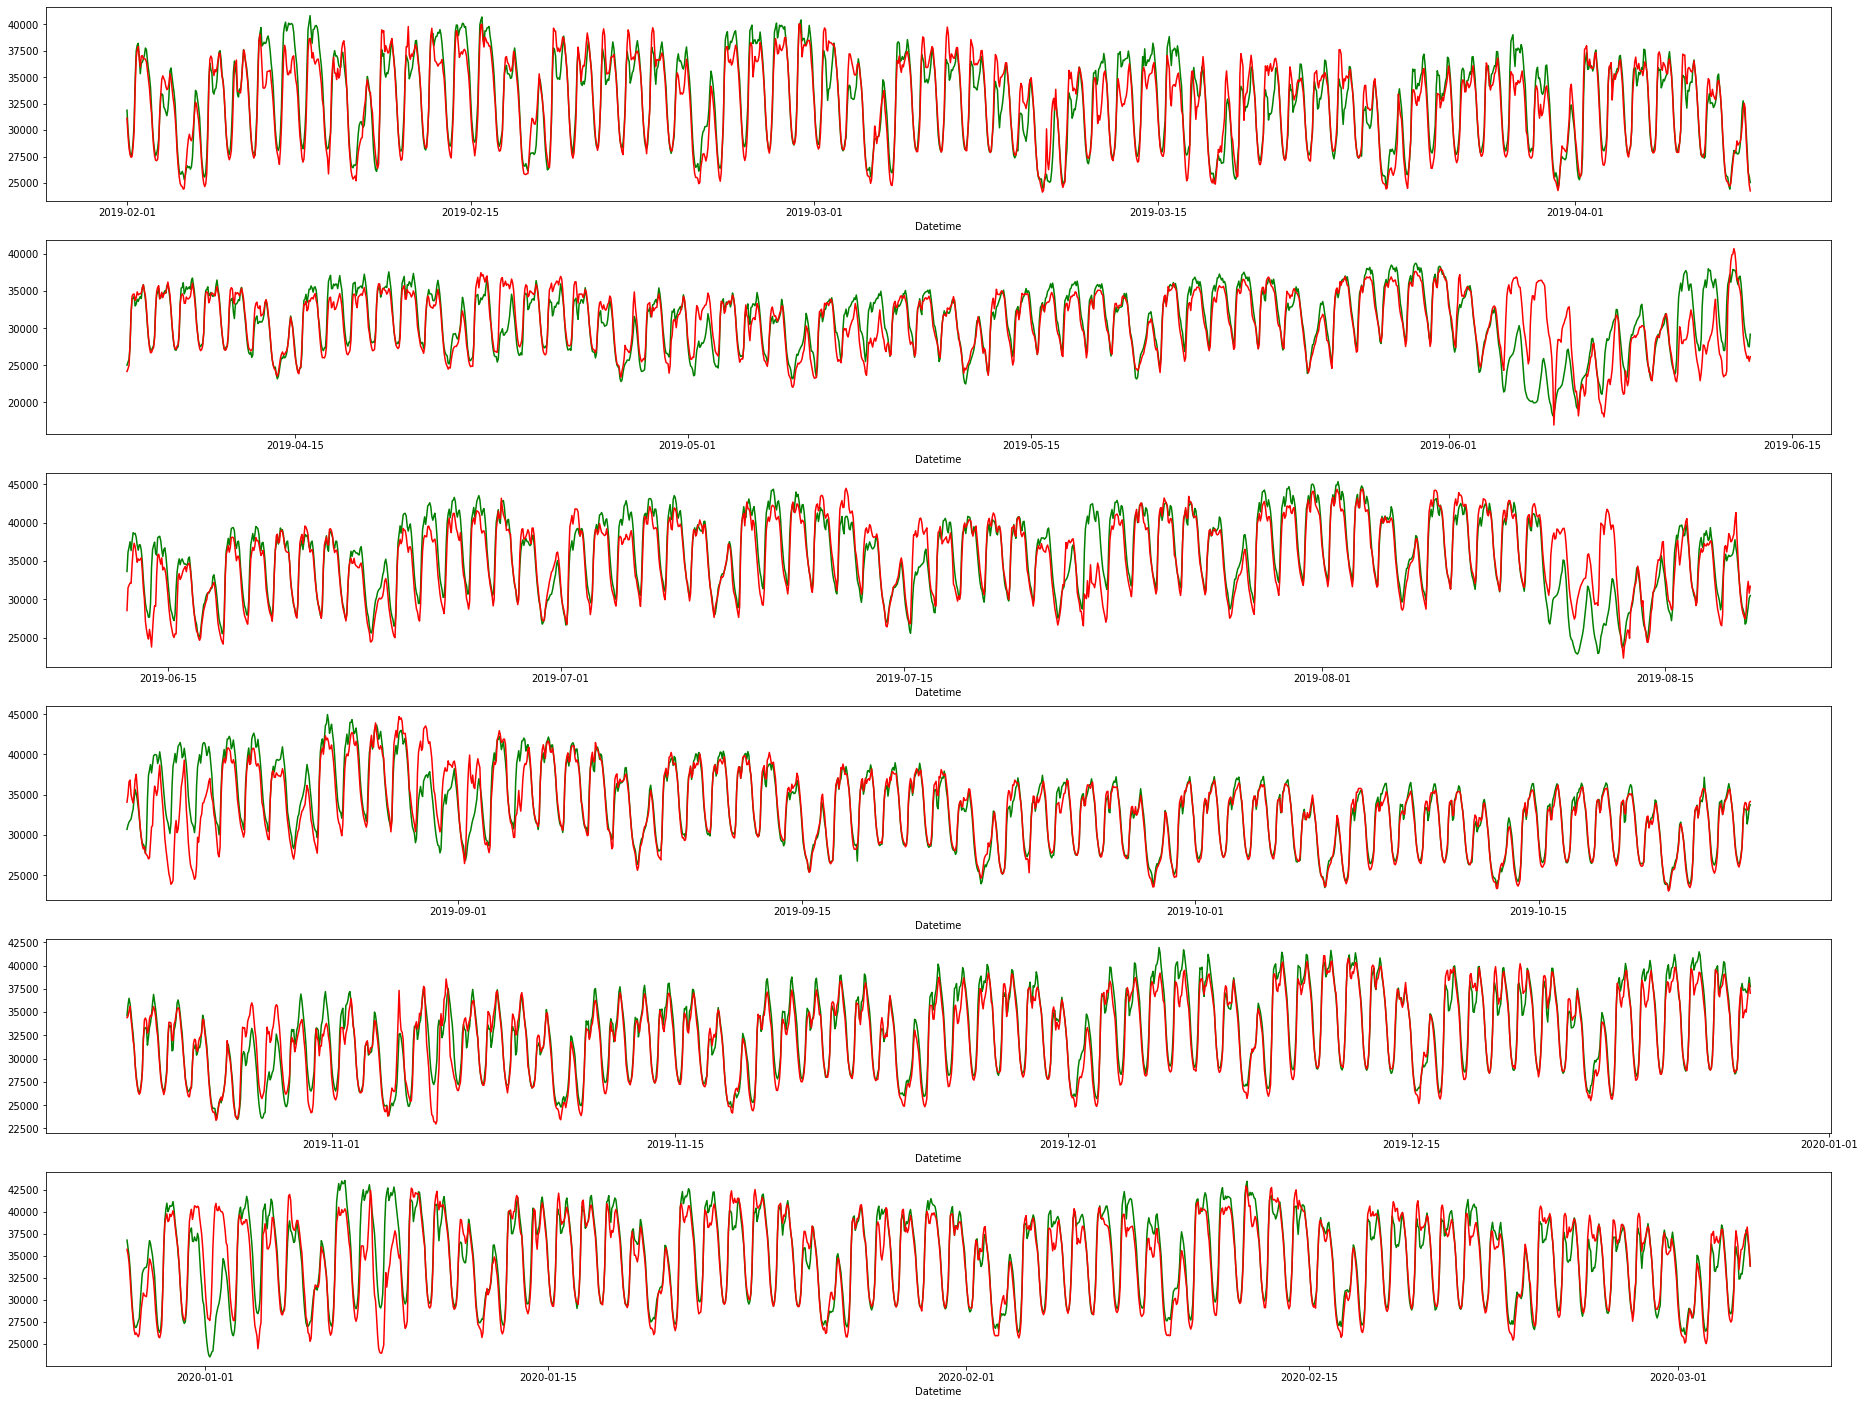

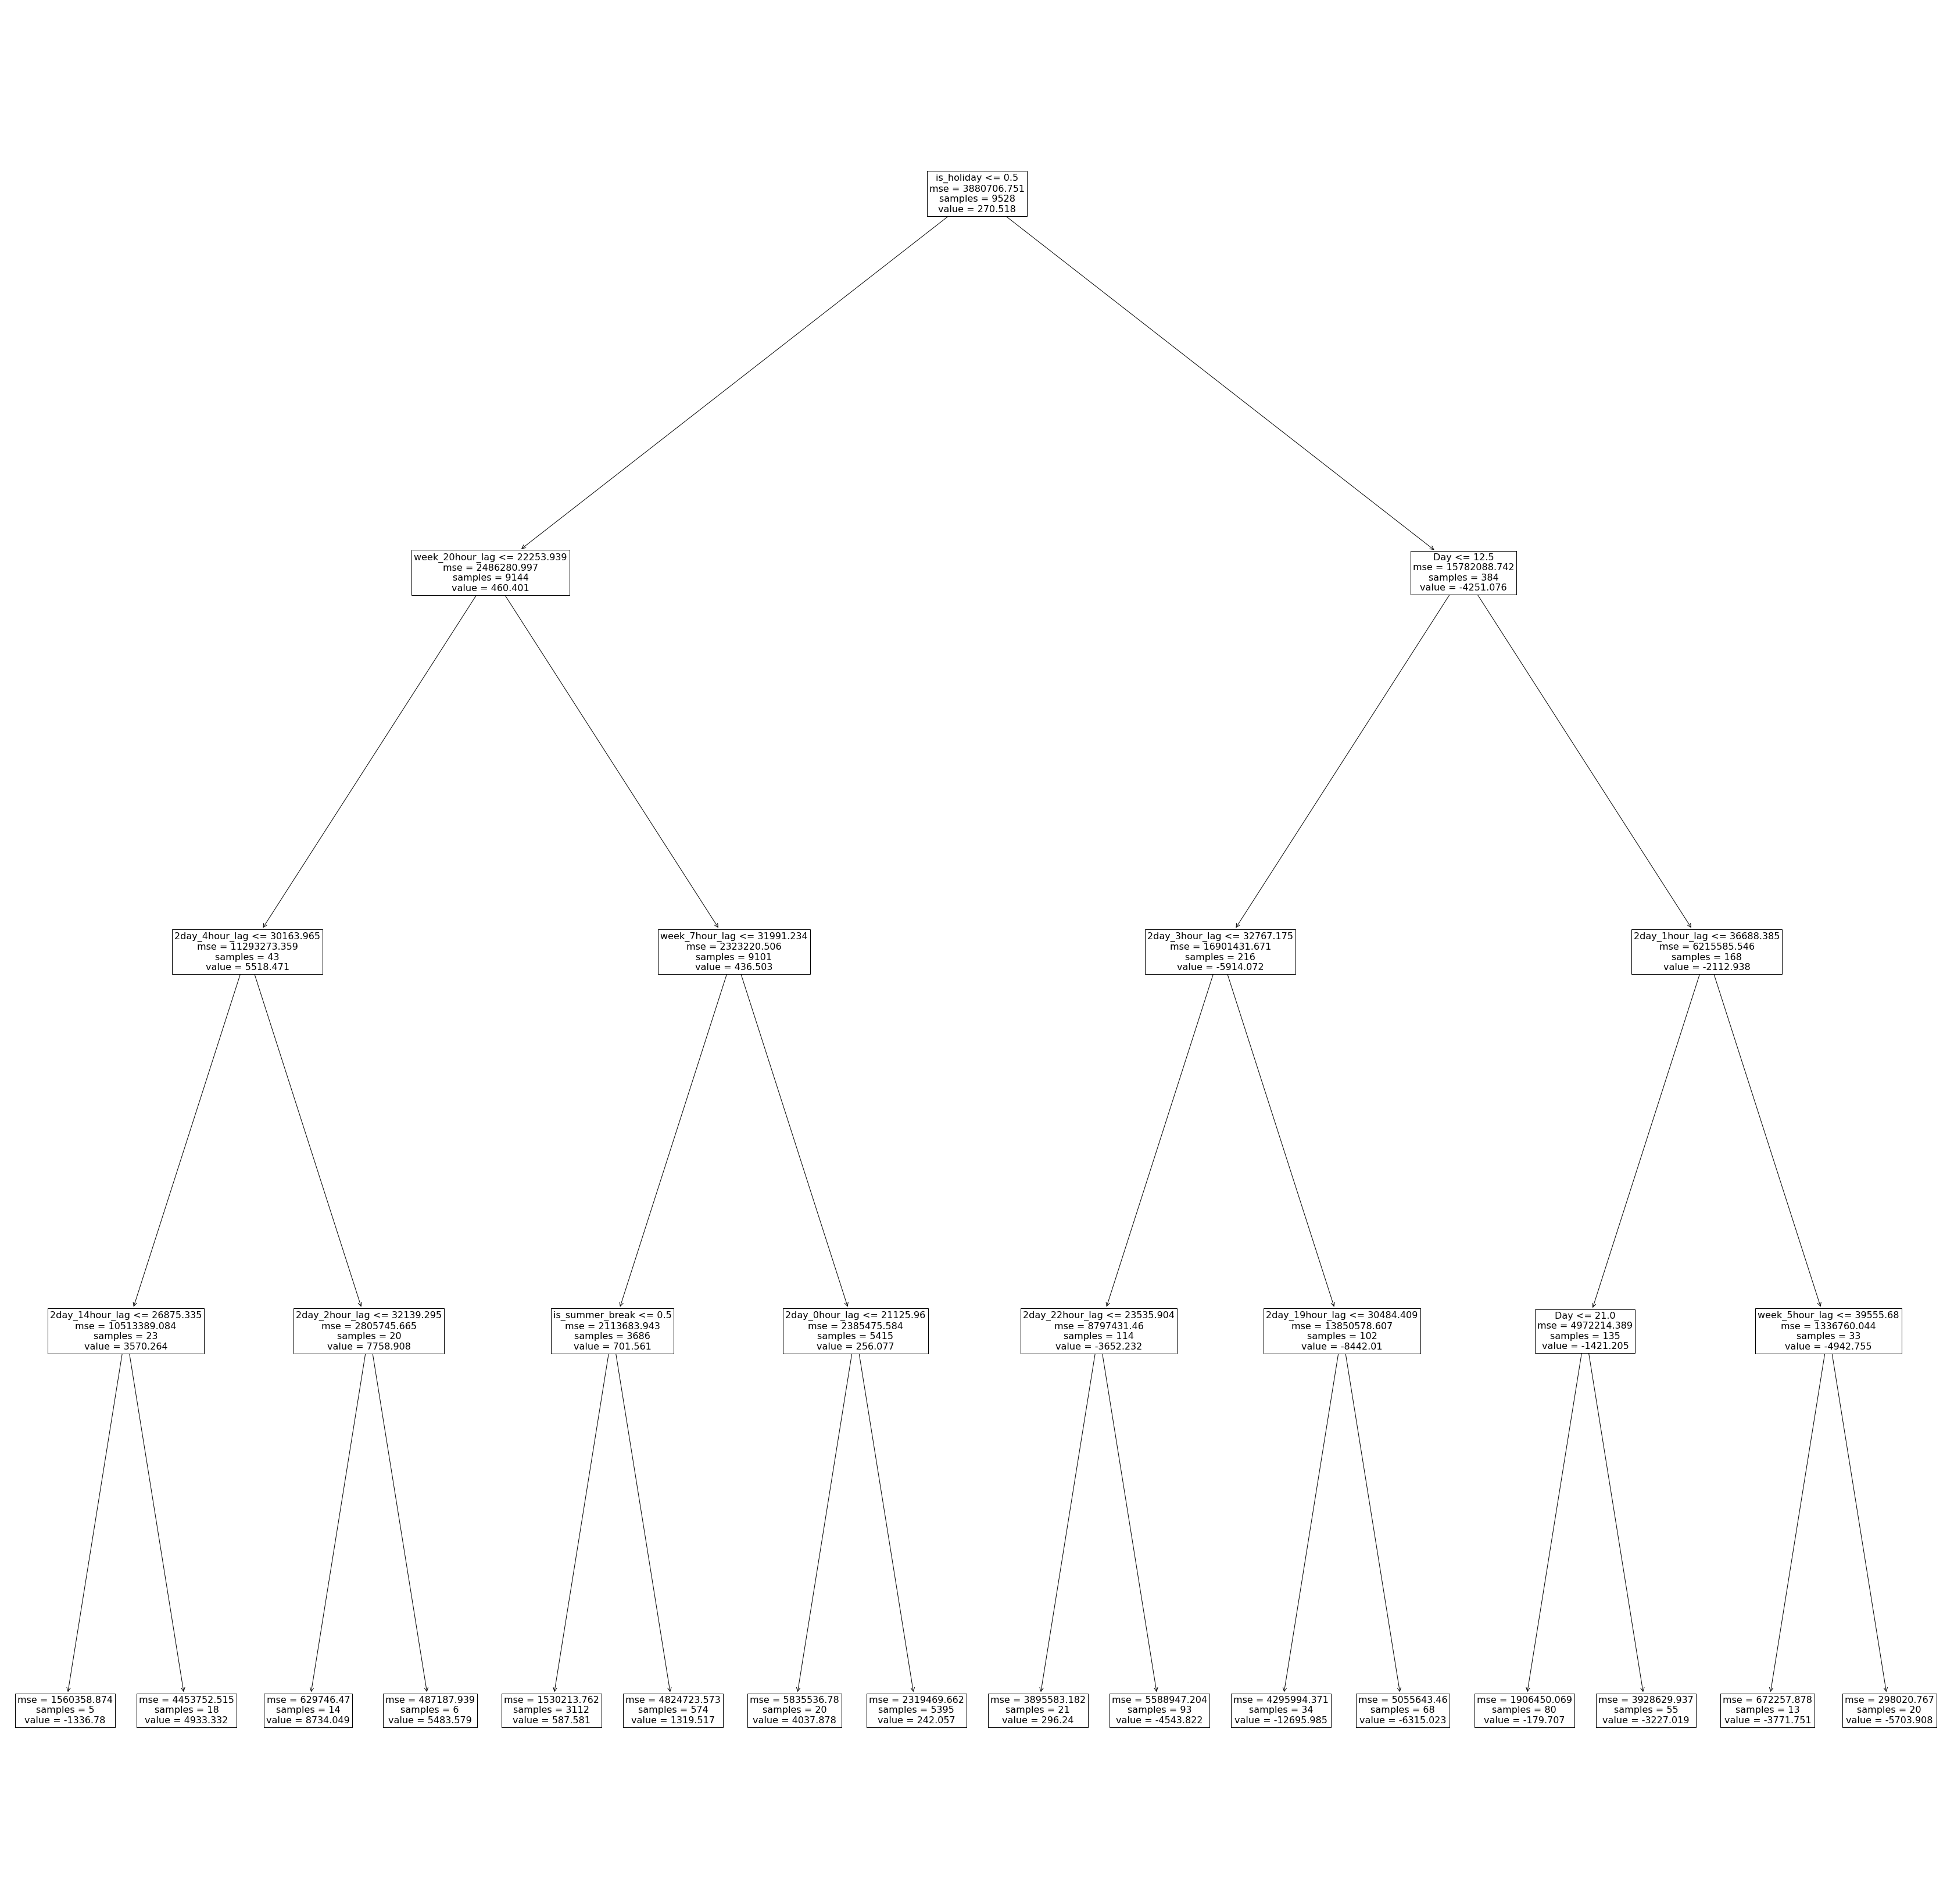

('Keras',
 1988.4382,
 0.062285724558912334,
 <tf.Tensor: shape=(), dtype=float32, numpy=1248.1774>,
 <tf.Tensor: shape=(), dtype=float32, numpy=3.8238955>)

In [0]:
y_pred=model.predict(valid_df.drop(columns=["Date","Datetime","Consumption"])).reshape((1,-1))[0]
y_true=valid_df["Consumption"].values
eval_function("Keras",y_true,y_pred,valid_df.drop(columns=["Date","Consumption"]))